# Astrometric analysis with ePSF

## Importing some modules

In [1]:
import copy, warnings
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf
from astropy.modeling import models, fitting
from astropy.nddata import NDData
from astropy.stats import sigma_clipped_stats
from astropy.table import Table
from astropy.visualization import simple_norm
from photutils.background import MMMBackground
from photutils.detection import find_peaks
from photutils.psf import EPSFBuilder, extract_stars

/Users/dkawata/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Reading a fits file

In [2]:
hdu = pf.open("img_ver1_2_A.fits")[0]
data = hdu.data.astype(np.float32)
norm = simple_norm(data, 'sqrt', percent=99.)

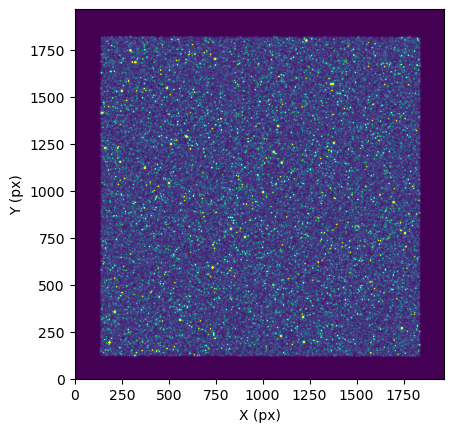

In [3]:
plt.imshow(data, norm=norm, origin='lower', cmap='viridis')
plt.xlabel('X (px)')
plt.ylabel('Y (px)')
plt.show()

In [4]:
np.shape(data)

(1968, 1968)

### Find Peaks

In [5]:
# Finding peaks.
#    mag = 12.0       # Object magnitude.
mag = 10.5
threshold = 3000.*10.**((mag-12.0)/(-2.5))
peaks_tbl = find_peaks(data, threshold=threshold)

In [6]:
peaks_tbl['peak_value'].info.format = '%.8g'  # for consistent table output
print(peaks_tbl)

x_peak y_peak peak_value
------ ------ ----------
  1756    137  13934.844
   325    139    12769.6
  1573    139  20320.445
  1110    141  12341.953
   449    145   12217.55
   434    148  19162.518
   357    151   15211.35
   ...    ...        ...
  1233   1800  12578.366
  1824   1803  13998.074
   515   1806  16758.998
  1128   1808  13875.277
  1259   1808  12587.796
  1821   1810  15674.368
  1738   1814  15973.133
Length = 585 rows


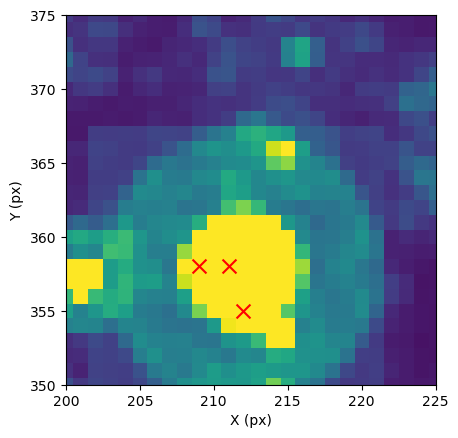

In [7]:
plt.imshow(data, norm=norm,  origin='lower', cmap='viridis')
plt.scatter(peaks_tbl['x_peak'], peaks_tbl['y_peak'], s=100, c='red', marker='x')
plt.xlim(200, 225)
plt.ylim(350, 375)
plt.xlabel('X (px)')
plt.ylabel('Y (px)')
plt.show()

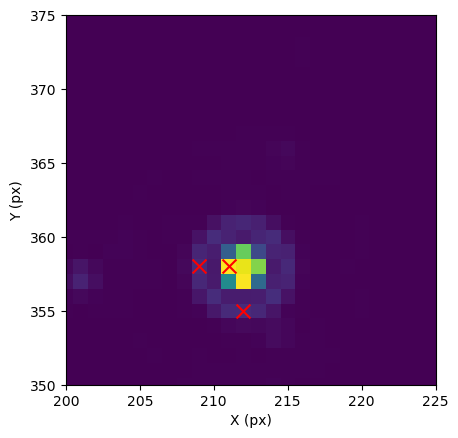

In [8]:
plt.imshow(data, origin='lower', cmap='viridis')
plt.scatter(peaks_tbl['x_peak'], peaks_tbl['y_peak'], s=100, c='red', marker='x')
plt.xlim(200, 225)
plt.ylim(350, 375)
plt.xlabel('X (px)')
plt.ylabel('Y (px)')
plt.show()

### Read input stellar data

In [9]:
# Loading stellar-plate data.
original = np.loadtxt("galcen_star_plate.csv",skiprows=1,delimiter=",")

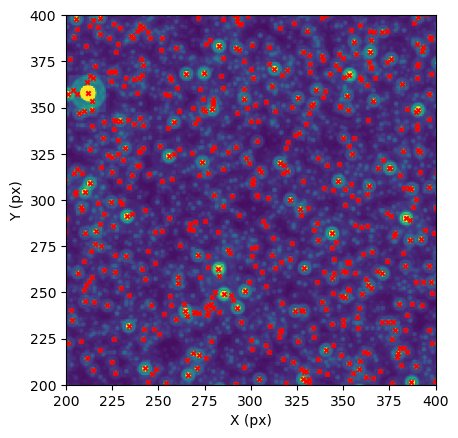

In [10]:
plt.imshow(data, norm=norm, origin='lower', cmap='viridis')
maglimit = 17.0
plt.scatter(original[original[:, 6]<maglimit, 3]-1, original[original[:,6]<maglimit, 2]-1, s=10, c='red', marker='x')
plt.xlim(200, 400)
plt.ylim(200, 400)
plt.xlabel('X (px)')
plt.ylabel('Y (px)')
plt.show()

In [13]:
Nbright = len(original[(original[:,6]>9.5)*(original[:,6]<12.5)*(original[:,3]>30)*(original[:,3]<1938)*(original[:,2]>30)*(original[:,2]<1938)])
print(' N of stars 9.5<Hw<12.5 =', Nbright)

 N of stars 9.5<Hw<12.5 = 554


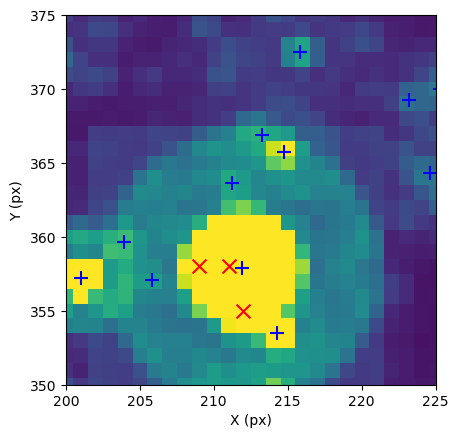

In [14]:
plt.imshow(data, norm=norm,  origin='lower', cmap='viridis')
plt.scatter(peaks_tbl['x_peak'], peaks_tbl['y_peak'], s=100, c='red', marker='x')
plt.scatter(original[original[:, 6]<maglimit, 3]-1, original[original[:,6]<maglimit, 2]-1, s=100, c='blue', marker='+')
plt.xlim(200, 225)
plt.ylim(350, 375)
plt.xlabel('X (px)')
plt.ylabel('Y (px)')
plt.show()

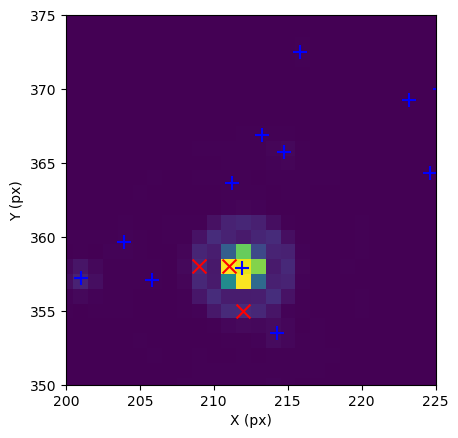

In [15]:
plt.imshow(data, origin='lower', cmap='viridis')
plt.scatter(peaks_tbl['x_peak'], peaks_tbl['y_peak'], s=100, c='red', marker='x')
plt.scatter(original[original[:, 6]<maglimit, 3]-1, original[original[:,6]<maglimit, 2]-1, s=100, c='blue', marker='+')
plt.xlim(200, 400)
plt.xlim(200, 225)
plt.ylim(350, 375)
plt.xlabel('X (px)')
plt.ylabel('Y (px)')
plt.show()

In [16]:
# Removing detections near edge.
mask_size = 25 
hsize = (mask_size - 1) / 2
x = peaks_tbl['x_peak'] 
y = peaks_tbl['y_peak'] 
mask = ((x > hsize) & (x < (data.shape[1] -1 - hsize)) &
            (y > hsize) & (y < (data.shape[0] -1 - hsize)))
stars_tbl = Table()
stars_tbl['x'] = x[mask]
stars_tbl['y'] = y[mask]
print(stars_tbl)

 x    y  
---- ----
1756  137
 325  139
1573  139
1110  141
 449  145
 434  148
 357  151
 ...  ...
1233 1800
1824 1803
 515 1806
1128 1808
1259 1808
1821 1810
1738 1814
Length = 585 rows


Text(0, 0.5, 'Y (px)')

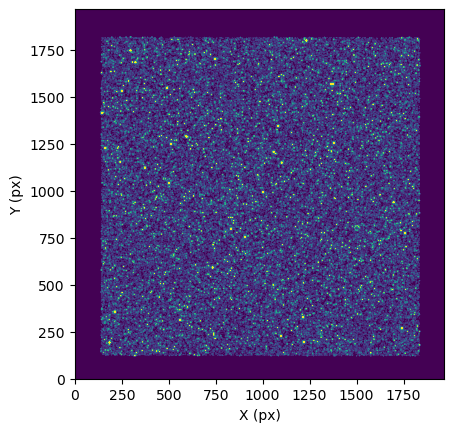

In [17]:
# Subtracting background.
mean_val, median_val, std_val = sigma_clipped_stats(data, sigma=2.)  
image = copy.deepcopy(data)
data -= mean_val
plt.imshow(data, norm=norm, origin='lower', cmap='viridis')
plt.xlabel('X (px)')
plt.ylabel('Y (px)')

(1968, 1968)


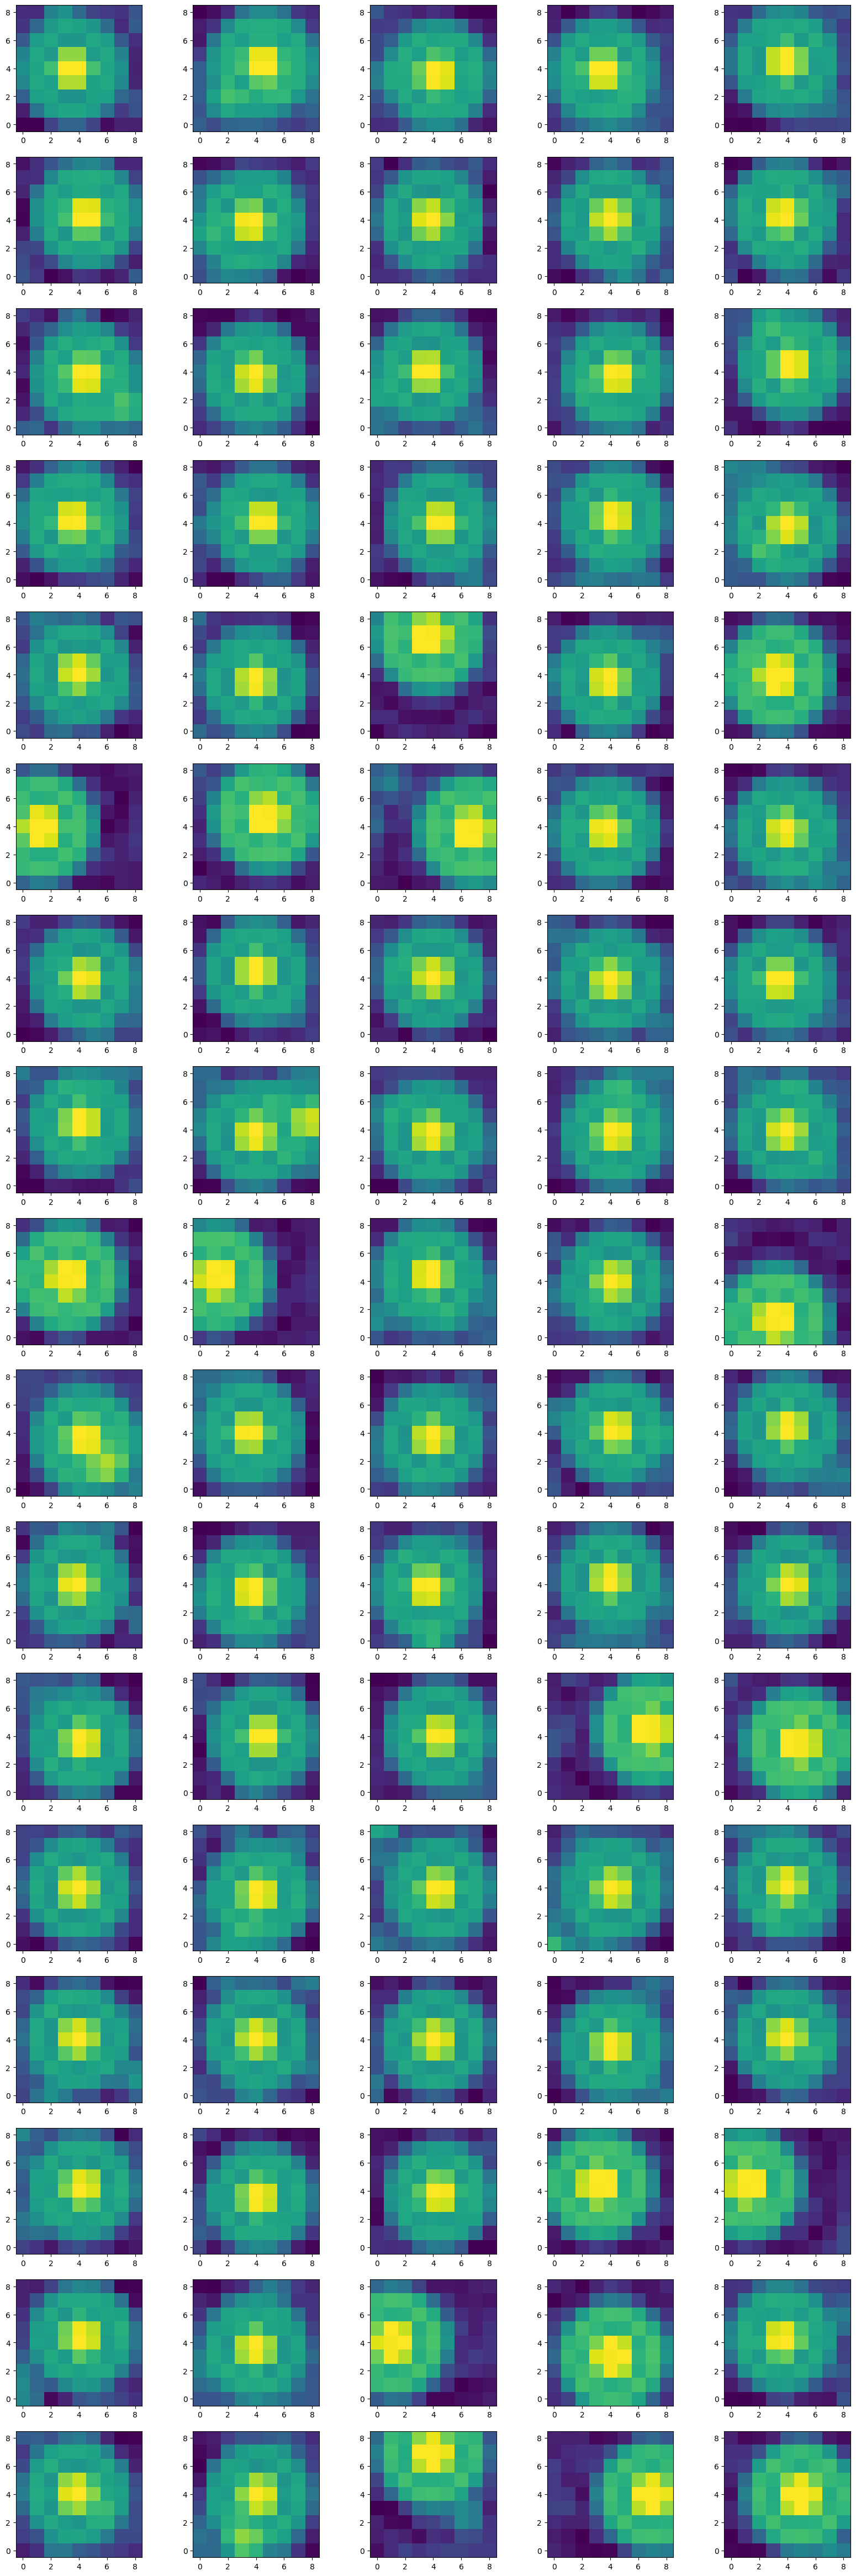

In [18]:
# Extracting stellar images.
ext_size  = 9
nddata = NDData(data=data)
print(nddata.data.shape)
stars = extract_stars(nddata, stars_tbl, size=ext_size)
nrows = 17
ncols = 5
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 60), squeeze=True)
ax = ax.ravel()
for i in range(nrows*ncols):
    norm = simple_norm(stars[i], 'log', percent=99.)
    ax[i].imshow(stars[i], norm=norm, origin='lower', cmap='viridis')
plt.show()

### Make ePSF

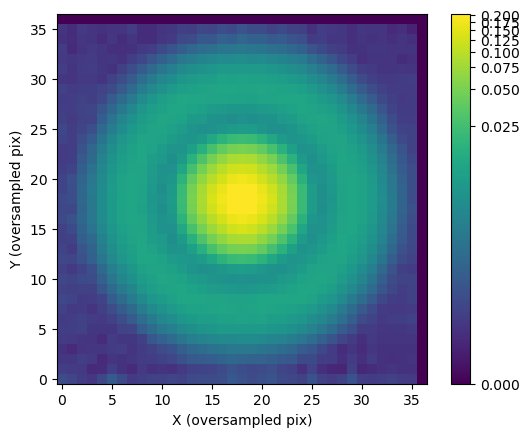

In [19]:
# Making ePSF.
n_oversample = 4 # Number of oversampling for ePSF.
n_maxiter    = 3 # Max. number of iteration for making ePSF.
norm_radius  = 5.5 # Number of undersampled pixels which determines the radius for flux normalization of ePSF.
recentering_boxsize = 5 #  Number of undersampled pixels which determines the box size for ePSF recentering calculation.

epsf_builder = EPSFBuilder(oversampling=n_oversample,
                           maxiters=n_maxiter, progress_bar=False,
                           norm_radius=norm_radius, recentering_boxsize=recentering_boxsize,
                           center_accuracy=0.001)
epsf, fitted_stars = epsf_builder(stars)
norm = simple_norm(epsf.data, 'log', percent=99.)
    
plt.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
plt.xlabel('X (oversampled pix)')
plt.ylabel('Y (oversampled pix)')
plt.colorbar()
plt.show()

In [20]:
print(' centre_flat =', fitted_stars.center_flat, np.shape(fitted_stars.center_flat))

 centre_flat = [[1755.50751798  136.9107665 ]
 [ 325.49346996  139.40395892]
 [1573.3502453   138.54871743]
 ...
 [1258.50812108 1808.17123935]
 [1821.36607648 1810.05515145]
 [1737.688396   1813.7316657 ]] (585, 2)


number of stars brighter than  12.5 = 585


(200.0, 400.0)

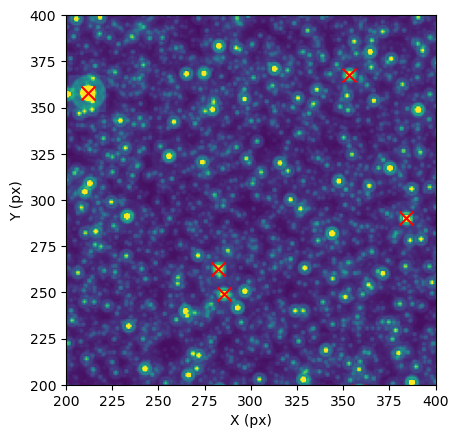

In [21]:
# Subtracting background.
maglimit = 12.5
norm = simple_norm(data, 'sqrt', percent=99.)
print('number of stars brighter than ', maglimit, '=', len(original[original[:,6]<maglimit, 2]))
plt.imshow(data, norm=norm, origin='lower', cmap='viridis')
plt.scatter(original[original[:, 6]<maglimit, 3]-1, original[original[:,6]<maglimit, 2]-1, s=100, c='red', marker='x')
plt.xlabel('X (px)')
plt.ylabel('Y (px)')
plt.xlim(200, 400)
plt.ylim(200, 400)


Text(0, 0.5, 'Y (px)')

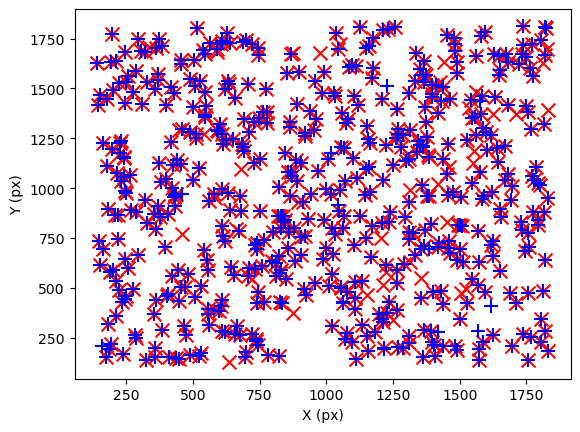

In [22]:
plt.scatter(original[original[:, 6]<maglimit, 3]-1, original[original[:,6]<maglimit, 2]-1, s=100, c='red', marker='x')
plt.scatter(fitted_stars.center_flat[:, 0], fitted_stars.center_flat[:, 1],  s=100, c='blue', marker='+')
plt.xlabel('X (px)')
plt.ylabel('Y (px)')
# plt.xlim(200, 300)
# plt.ylim(200, 300)

In [23]:
# Cross-matching the data.
xc_array = []
maglim_o = maglimit+1.0
# search stars only for brighter stars
stars_list = original[original[:, 6] < maglim_o]
print(np.shape(stars_list))

# for loop for fitted stars
nfitted_stars = len(fitted_stars.center_flat[:, 0])
print(' N fitted stars=', np.shape(fitted_stars.center_flat), nfitted_stars)
print(' fitted_stars.center_flat', np.shape(fitted_stars.center_flat[0]))
for i in range(nfitted_stars):
    xdiff = fitted_stars.center_flat[i, 0]-stars_list[:, 3]+1.0
    ydiff = fitted_stars.center_flat[i, 1]-stars_list[:, 2]+1.0
    dist2 = xdiff**2+ydiff**2
    # closest
    mindx = np.argmin(dist2)
    # print(' indx, dist, x, y s, f=', mindx, dist2[mindx], o[3]-1.0, o[2]-1.0, fitted_stars.center_flat[mindx])
    # print(dist2[mindx], stars_list[mindx, 3]-1.,stars_list[mindx, 2]-1.,fitted_stars.center_flat[i, 0], fitted_stars.center_flat[i, 1])
    xc_array.append([stars_list[mindx, 3]-1.,stars_list[mindx, 2]-1.,      # 1-origin -> 0-origin
                             fitted_stars.center_flat[i, 0],
                             fitted_stars.center_flat[i, 1]])
    if dist2[mindx]>0.6: 
        print(' star ', i, ' min dist =', np.sqrt(dist2[mindx]), stars_list[mindx, 6])
        plt.imshow(data, norm=norm, origin='lower', cmap='viridis')
        plt.scatter(fitted_stars.center_flat[i, 0], fitted_stars.center_flat[i, 1], s=100, c='blue', marker='+')
        plt.scatter(original[original[:, 6]<maglim_o, 3]-1, original[original[:,6]<maglim_o, 2]-1, s=100, c='red', marker='x')
        plt.xlabel('X (px)')
        plt.ylabel('Y (px)')
        plt.xlim(fitted_stars.center_flat[i, 0]-5.0, fitted_stars.center_flat[i, 0]+5.0)
        plt.ylim(fitted_stars.center_flat[i, 1]-5.0, fitted_stars.center_flat[i, 1]+5.0)
        plt.show()
xc_array = np.array(xc_array)
print(' number of stars brighter than ', maglim_o, ' in the list =', len(xc_array))

(1990, 7)
 N fitted stars= (585, 2) 585
 fitted_stars.center_flat (2,)
 number of stars brighter than  13.5  in the list = 585


In [24]:
# excluding bright stars
xc_array = []
maglim_o = maglimit+1.0
maglim_bright = 9.5
# search stars only for brighter stars
stars_list = original[original[:, 6] < maglim_o]
print(np.shape(stars_list))

# for loop for fitted stars
nfitted_stars = len(fitted_stars.center_flat[:, 0])
print(' N fitted stars=', np.shape(fitted_stars.center_flat), nfitted_stars)
print(' fitted_stars.center_flat', np.shape(fitted_stars.center_flat[0]))
for i in range(nfitted_stars):
    xdiff = fitted_stars.center_flat[i, 0]-stars_list[:, 3]+1.0
    ydiff = fitted_stars.center_flat[i, 1]-stars_list[:, 2]+1.0
    dist2 = xdiff**2+ydiff**2
    # closest
    mindx = np.argmin(dist2)
    if stars_list[mindx, 6]> maglim_bright:
        # print(' indx, dist, x, y s, f=', mindx, dist2[mindx], o[3]-1.0, o[2]-1.0, fitted_stars.center_flat[mindx])
        # print(dist2[mindx], stars_list[mindx, 3]-1.,stars_list[mindx, 2]-1.,fitted_stars.center_flat[i, 0], fitted_stars.center_flat[i, 1])
        xc_array.append([stars_list[mindx, 3]-1.,stars_list[mindx, 2]-1.,      # 1-origin -> 0-origin
                                 fitted_stars.center_flat[i, 0],
                                 fitted_stars.center_flat[i, 1], stars_list[mindx, 6]])

xc_array = np.array(xc_array)
print(' number of stars brighter than ', maglim_o, ' in the list =', len(xc_array))

(1990, 7)
 N fitted stars= (585, 2) 585
 fitted_stars.center_flat (2,)
 number of stars brighter than  13.5  in the list = 521


In [25]:
dx = xc_array[:,2] - xc_array[:,0]
dy = xc_array[:,3] - xc_array[:,1]
dx0 = dx - np.mean(dx)
dy0 = dy - np.mean(dy)
dist = np.sqrt(dx0**2+dy0**2)
dx_mean =  np.mean(dx)
dy_mean =  np.mean(dy)

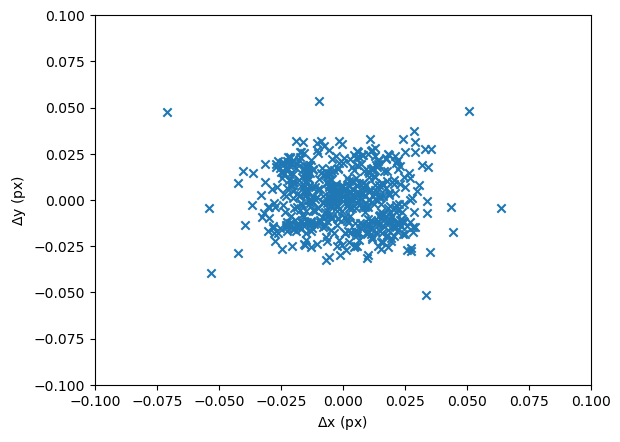

In [26]:
plt.scatter(dx0, dy0, marker='x')
plt.xlabel('$\Delta$x (px)')
plt.ylabel('$\Delta$y (px)')
plt.xlim([-0.1,0.1])
plt.ylim([-0.1,0.1])
plt.show()

In [27]:
# mean and std
print(' for all stars')
print(' number of stars fitted =', len(dist))
print(' mean deviation for dist =', np.mean(dist))
print(' std deviation for dist =', np.std(dist))
devlim = 0.1
print(' for stars their delta d <', devlim)
print(' number of stars fitted =', len(dist[dist<devlim]))
print(' mean deviation for dist =', np.mean(dist[dist<devlim]))
print(' std deviation for dist =', np.std(dist[dist<devlim]))

 for all stars
 number of stars fitted = 521
 mean deviation for dist = 0.024571067780623866
 std deviation for dist = 0.040544453792808216
 for stars their delta d < 0.1
 number of stars fitted = 514
 mean deviation for dist = 0.020866238498517917
 std deviation for dist = 0.010928192563730703


### Examples of bad cases

The contamination seems to be severe. 

 star  225  dist= 0.4312554172218639


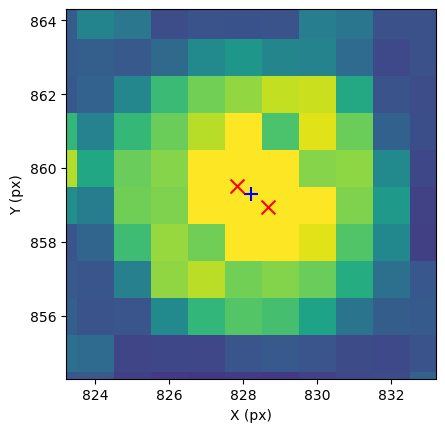

 star  324  dist= 0.6902631310224027


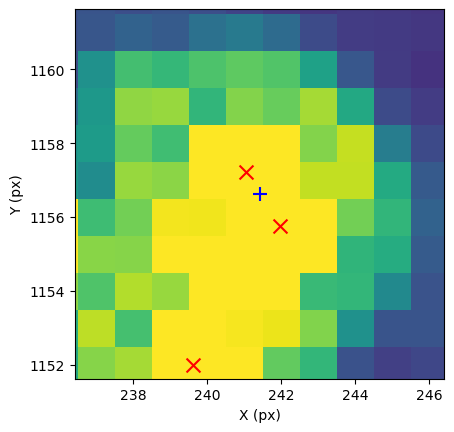

 star  435  dist= 0.36517952690937305


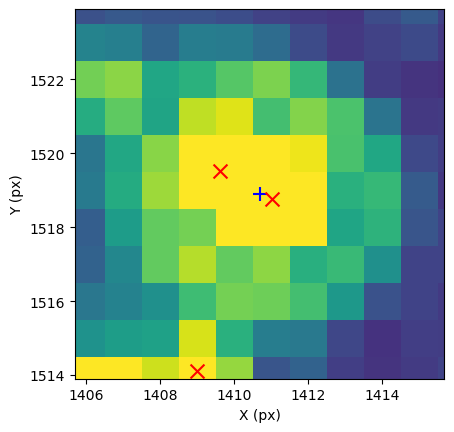

In [28]:

for i in range(len(dist)):
    if dist[i]>0.3: 
        print(' star ', i, ' dist=', dist[i])
        plt.imshow(data, norm=norm, origin='lower', cmap='viridis')
        plt.scatter(xc_array[i,2], xc_array[i,3], s=100, c='blue', marker='+')
        plt.scatter(original[original[:, 6]<15.0, 3]-1+dx_mean, original[original[:,6]<15.0, 2]-1+dy_mean, s=100, c='red', marker='x')
        # plt.scatter(xc_array[i,0]+dx_mean, xc_array[i,1]+dx_mean, s=100, c='red', marker='x')
        plt.xlabel('X (px)')
        plt.ylabel('Y (px)')
        plt.xlim(xc_array[i,2]-5.0, xc_array[i,2]+5.0)
        plt.ylim(xc_array[i,3]-5.0,xc_array[i,3]+5.0)
        plt.show()

### Example of the best cases

Cases with error <0.0085 pix. 

 dx and dy mean =  0.012380181291559662 0.018489496899152483
 N (dist<0.0085)= 71
 star  12  dist= 0.007049883044396212


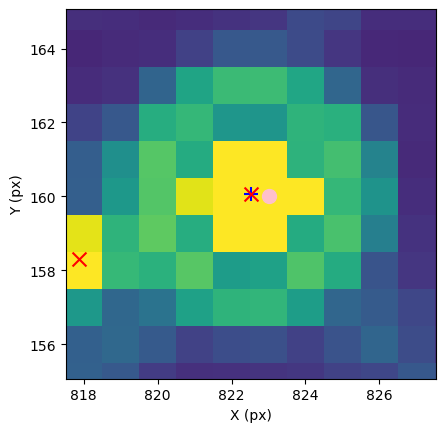

 star  26  dist= 0.006974846467973641


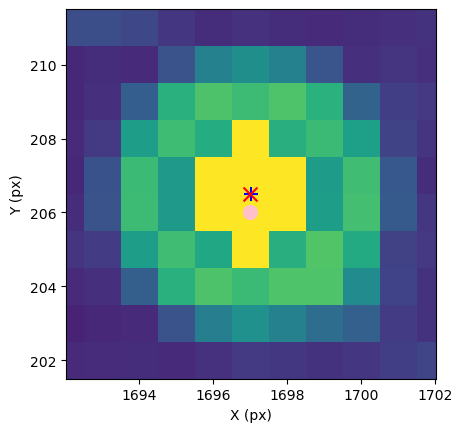

 star  34  dist= 0.005298716911568339


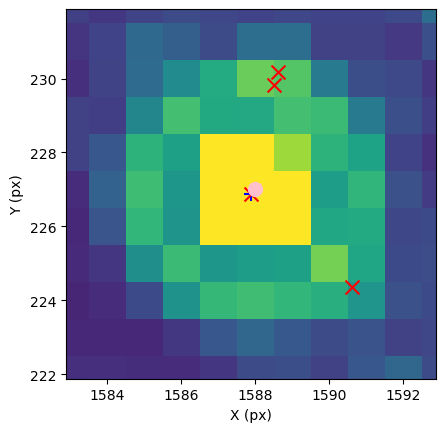

 star  36  dist= 0.0019748380881463735


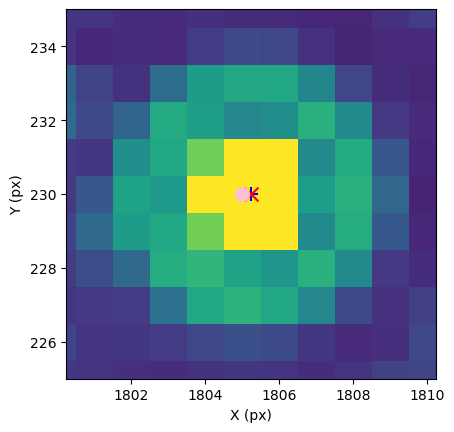

 star  48  dist= 0.0059169169802593975


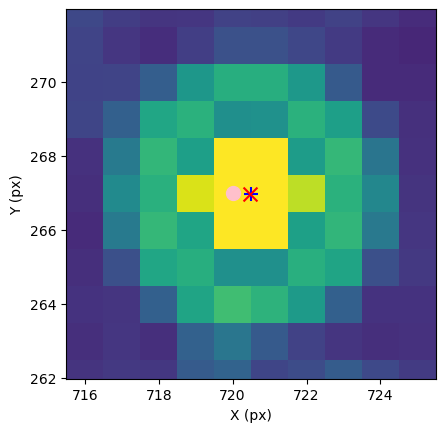

 star  50  dist= 0.00831271337380324


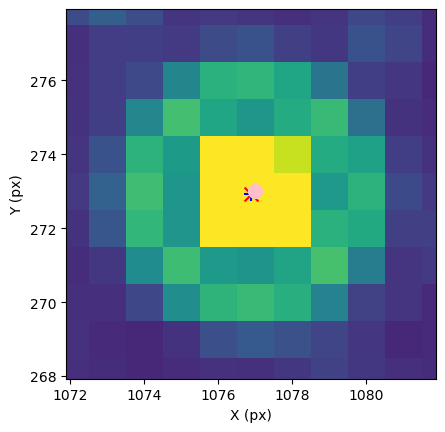

 star  56  dist= 0.0074204408504664355


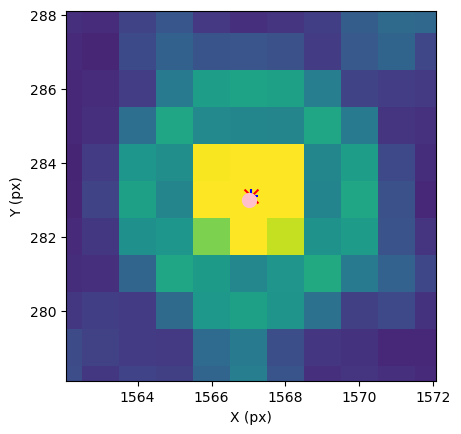

 star  57  dist= 0.005734608174164188


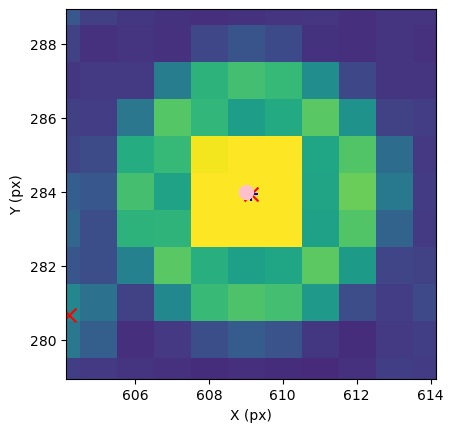

 star  66  dist= 0.008193443928405205


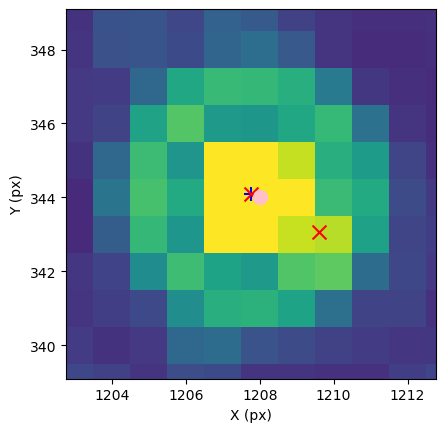

 star  78  dist= 0.007180306912870079


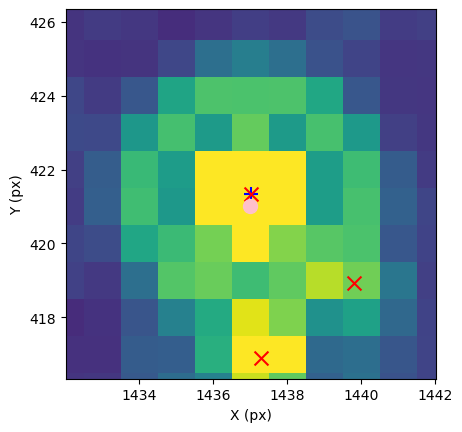

 star  86  dist= 0.005333401457382867


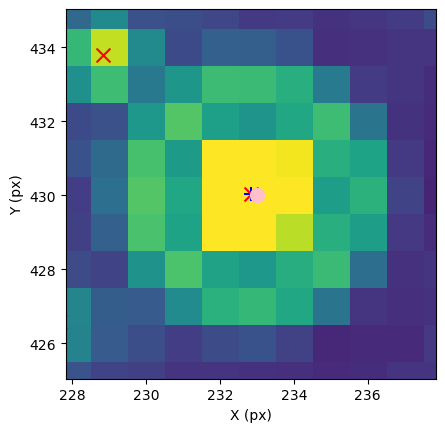

 star  88  dist= 0.004178396630936208


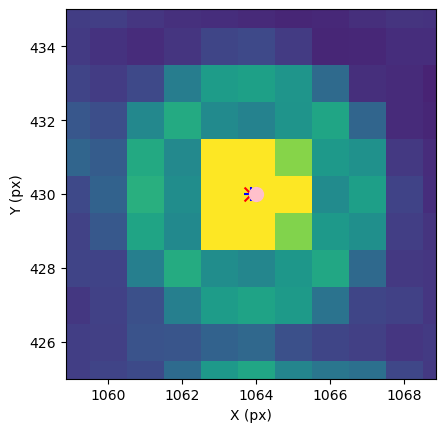

 star  94  dist= 0.0032519522109404394


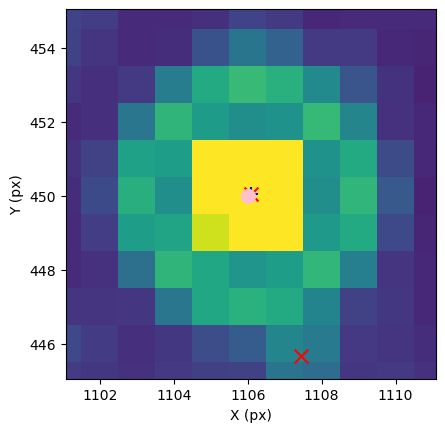

 star  103  dist= 0.0018611701997875954


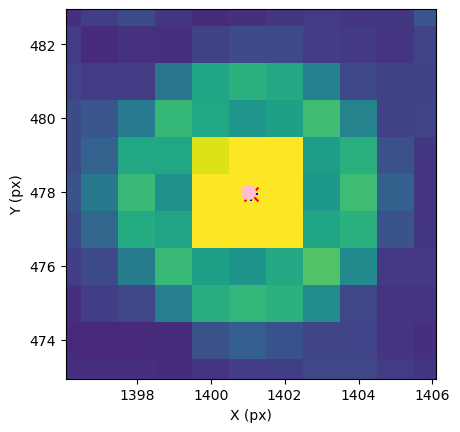

 star  119  dist= 0.005202340030094261


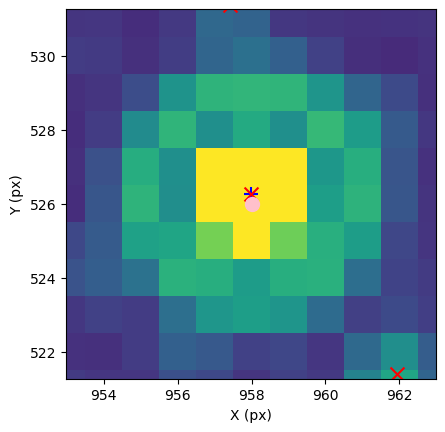

 star  122  dist= 0.005926060801468154


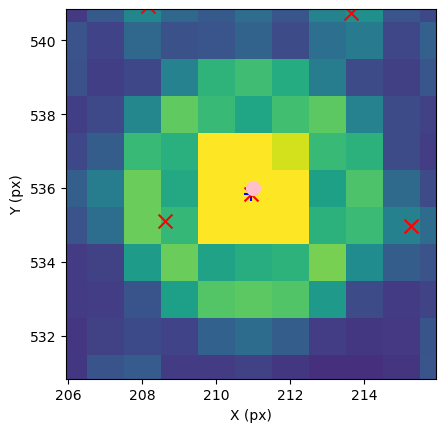

 star  134  dist= 0.004018120372342332


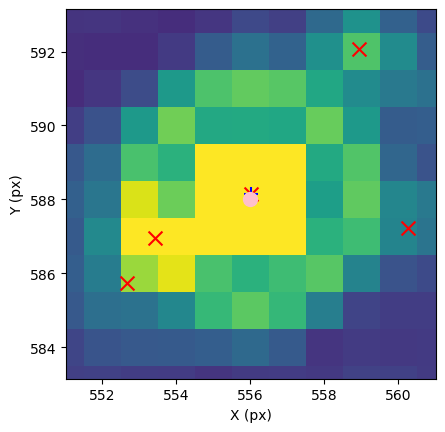

 star  143  dist= 0.0024242184960412126


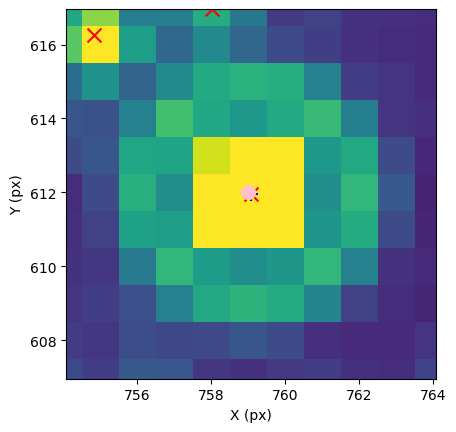

 star  149  dist= 0.008452954101046503


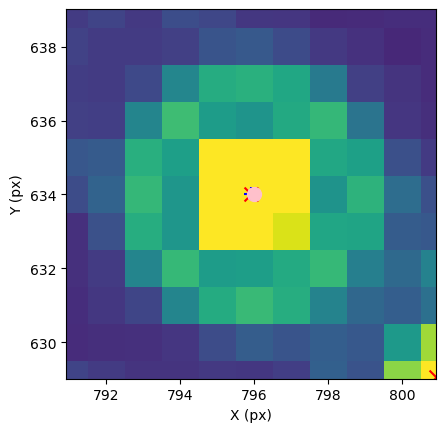

 star  155  dist= 0.004321911950525087


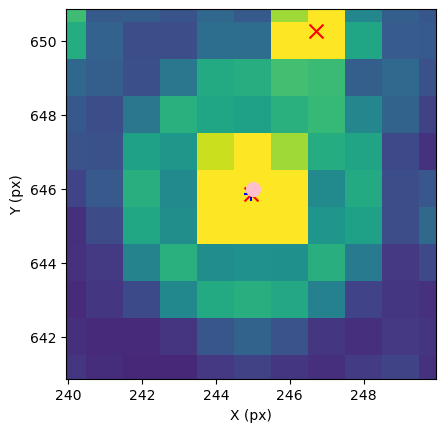

 star  156  dist= 0.007534843577051226


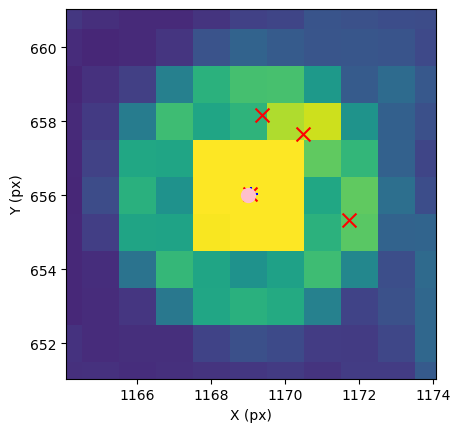

 star  163  dist= 0.00326526837934601


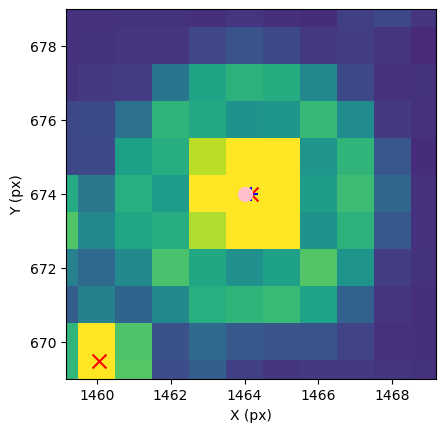

 star  167  dist= 0.004594717592722891


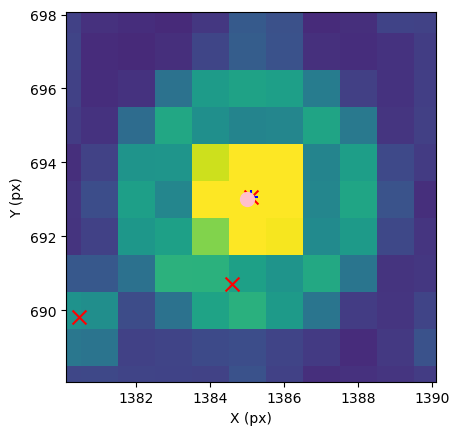

 star  174  dist= 0.005305134970134567


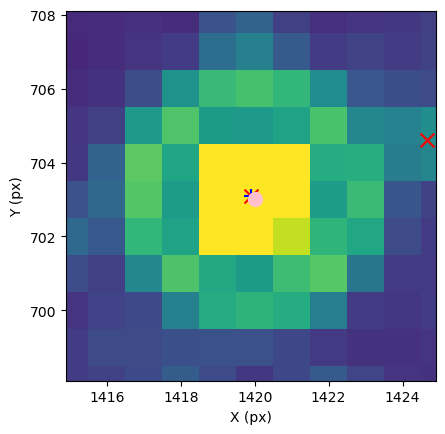

 star  181  dist= 0.003821925435503996


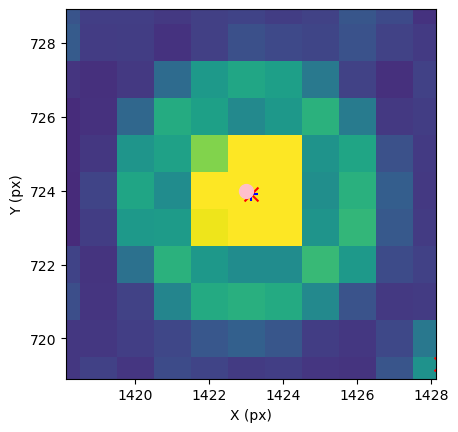

 star  191  dist= 0.005630131743521742


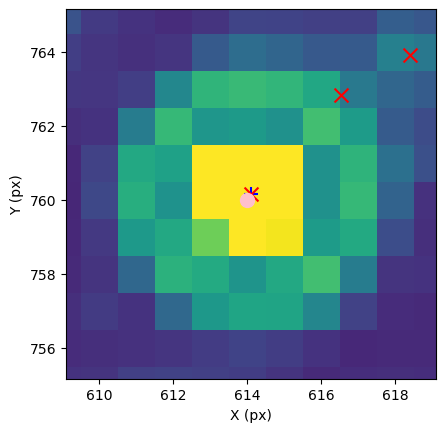

 star  197  dist= 0.005460654783571567


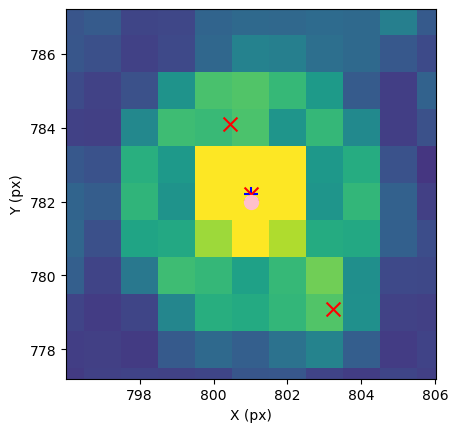

 star  207  dist= 0.006663483052074482


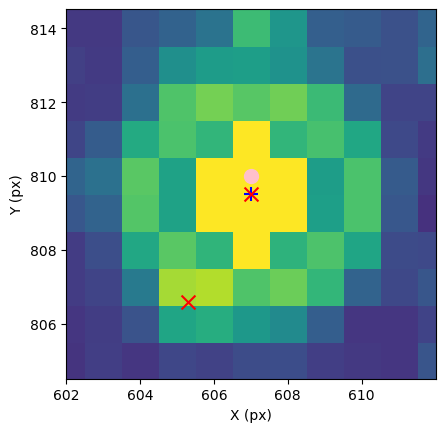

 star  213  dist= 0.005201499702824675


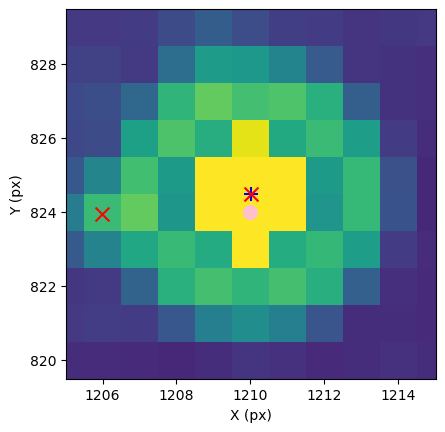

 star  214  dist= 0.004611244630654411


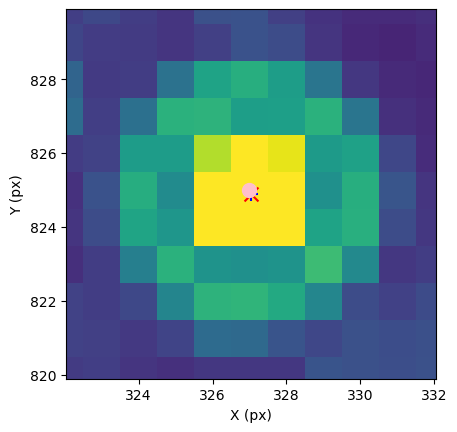

 star  222  dist= 0.0044151392344946895


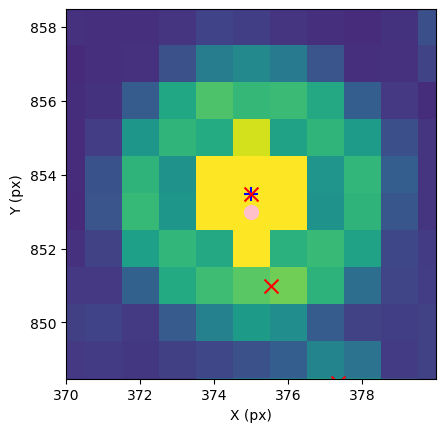

 star  236  dist= 0.005142676126610402


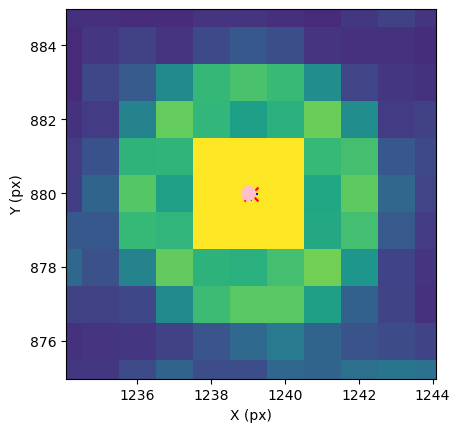

 star  237  dist= 0.004698211088347268


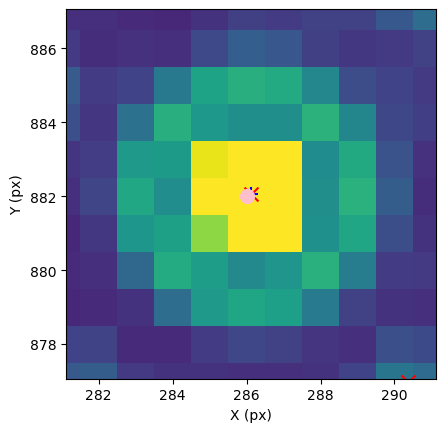

 star  247  dist= 0.006940026973763996


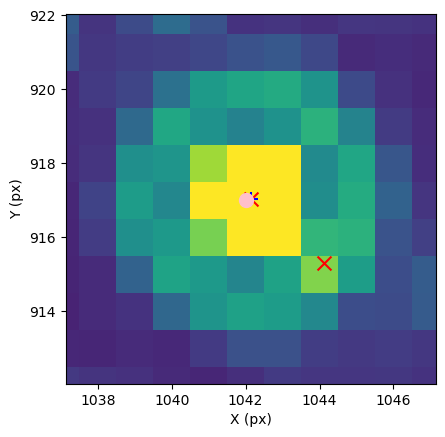

 star  256  dist= 0.004668938168706119


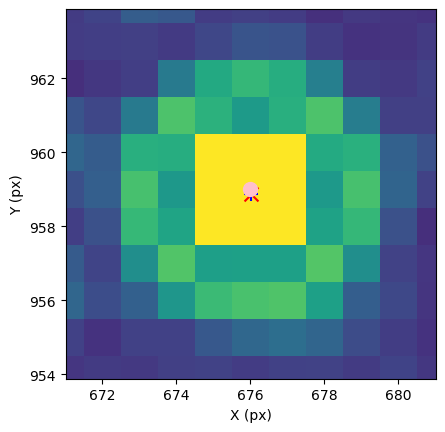

 star  259  dist= 0.007600410826266126


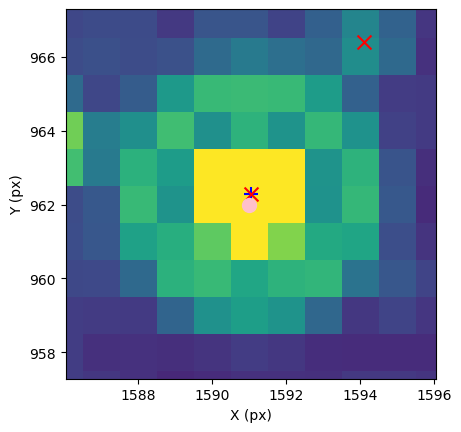

 star  267  dist= 0.004432889379482958


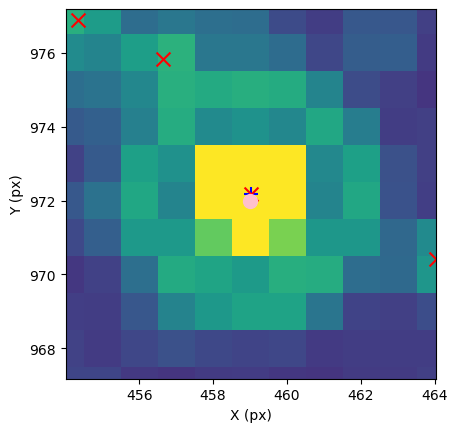

 star  269  dist= 0.00510622900813887


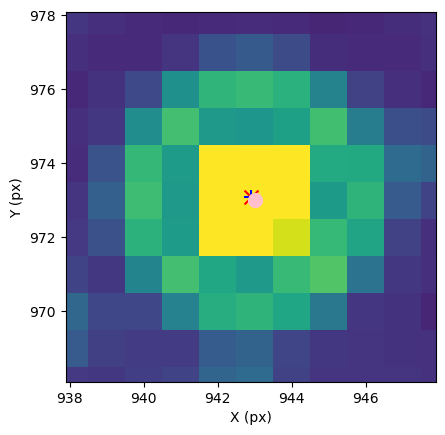

 star  277  dist= 0.0035284273070540773


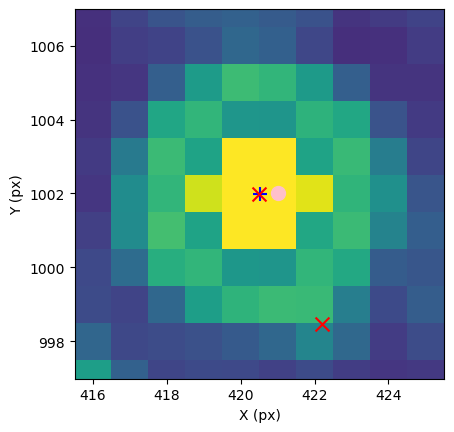

 star  293  dist= 0.006668249725963149


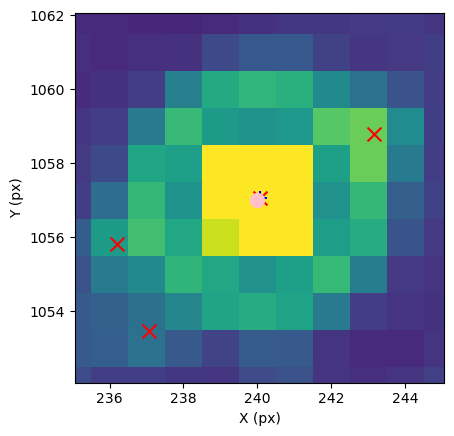

 star  297  dist= 0.006881870374676433


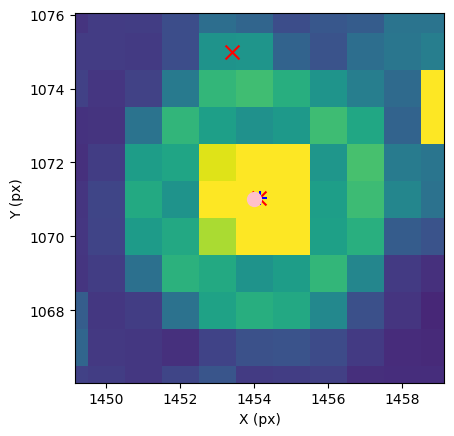

 star  298  dist= 0.0056684776857184906


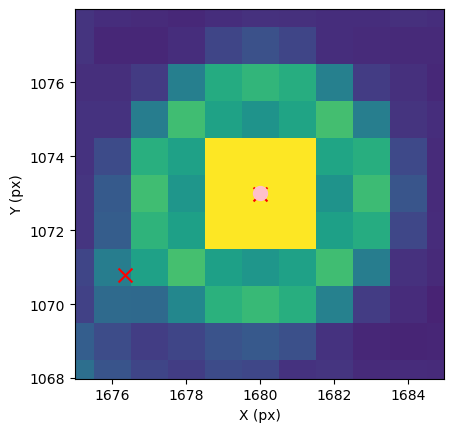

 star  301  dist= 0.004247555591940723


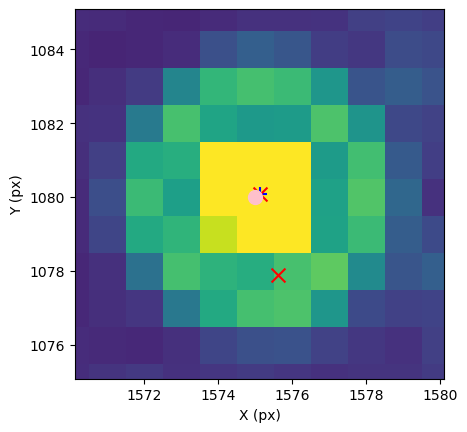

 star  305  dist= 0.00660790565966747


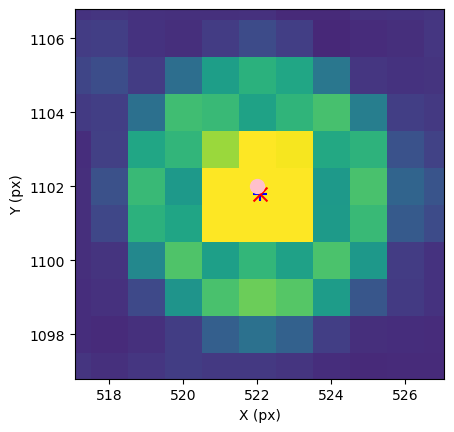

 star  307  dist= 0.0021447685593270534


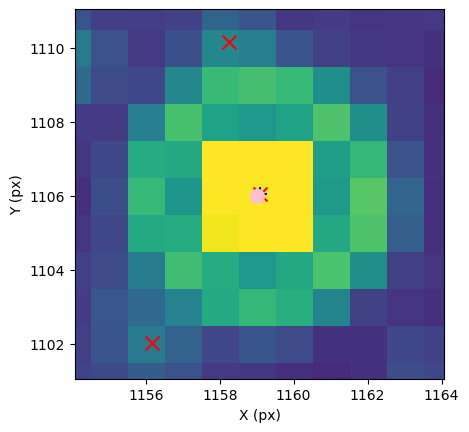

 star  311  dist= 0.007580884343922828


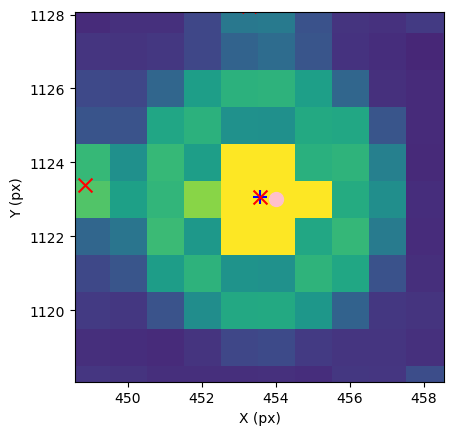

 star  319  dist= 0.004187968252057395


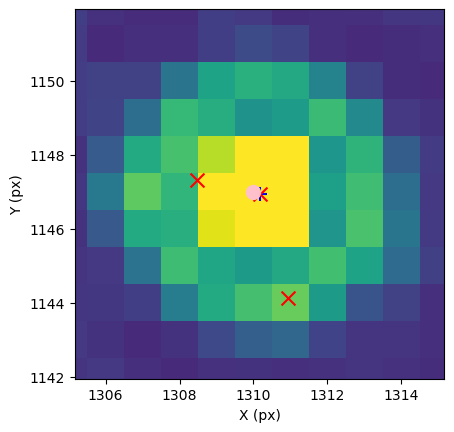

 star  320  dist= 0.003626436286889086


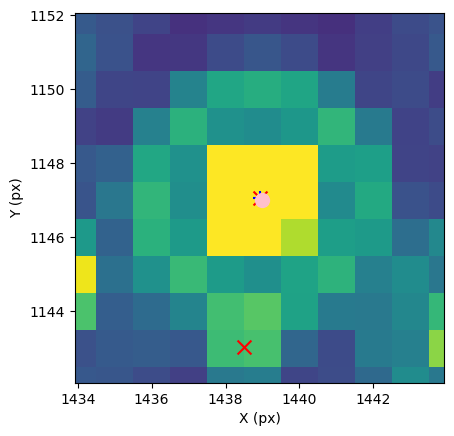

 star  327  dist= 0.004770251192842612


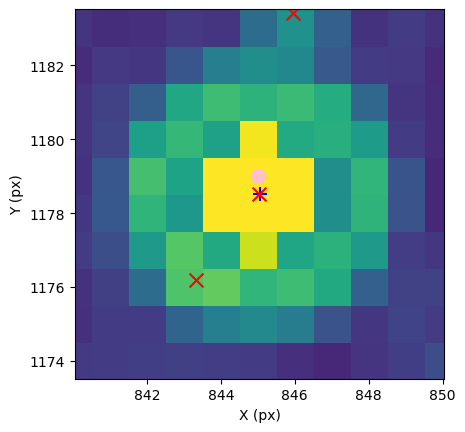

 star  350  dist= 0.007210555824516476


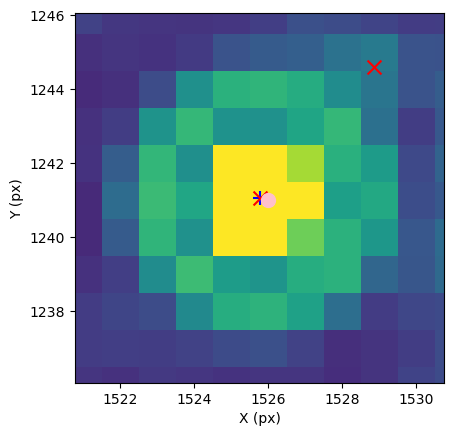

 star  364  dist= 0.001011385950829941


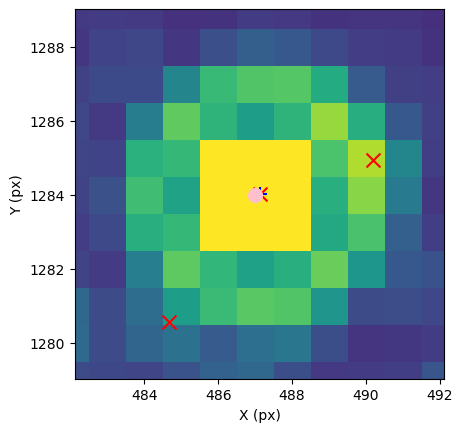

 star  367  dist= 0.0036843956966275317


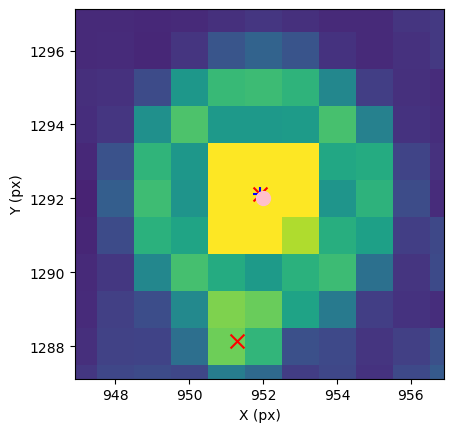

 star  371  dist= 0.005153619362225394


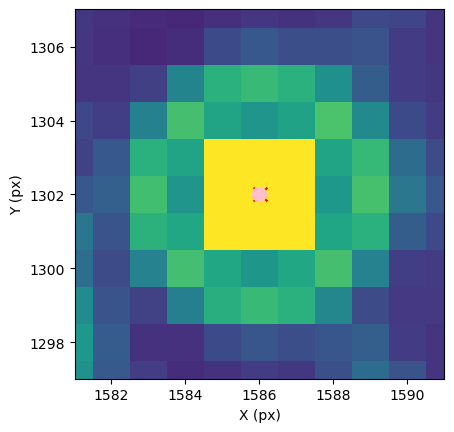

 star  375  dist= 0.006119581045701917


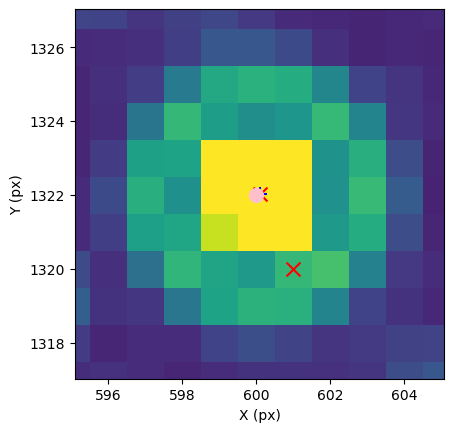

 star  376  dist= 0.005569407600463823


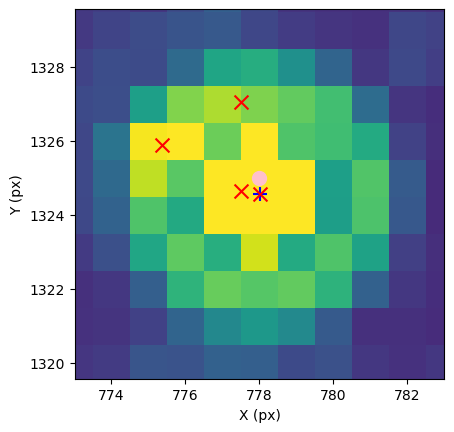

 star  382  dist= 0.00414774229219775


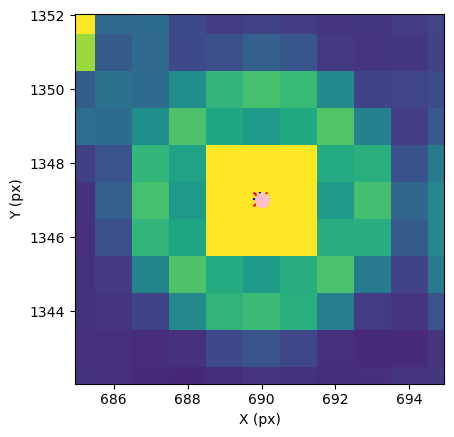

 star  394  dist= 0.0029929210229630043


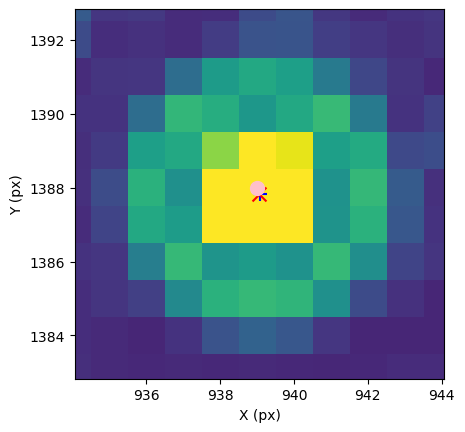

 star  395  dist= 0.007972699331874845


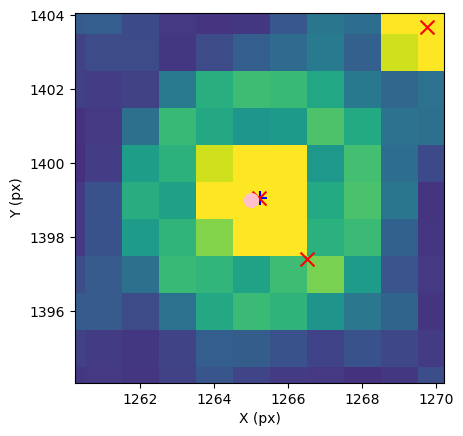

 star  402  dist= 0.007560314371357044


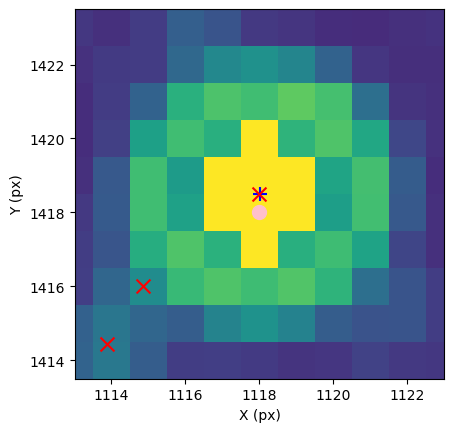

 star  406  dist= 0.0035194244121481222


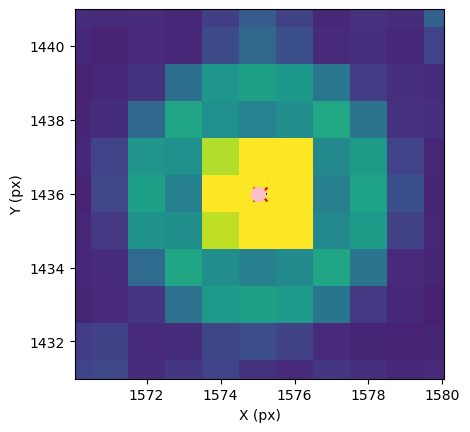

 star  414  dist= 0.004506550388097655


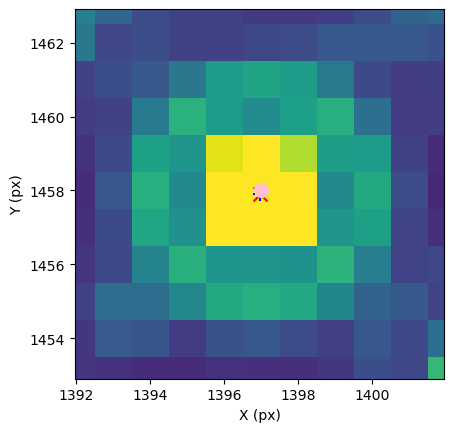

 star  420  dist= 0.007847398591990877


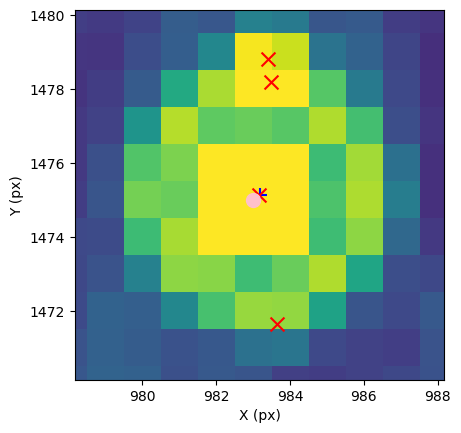

 star  426  dist= 0.0038188267058428035


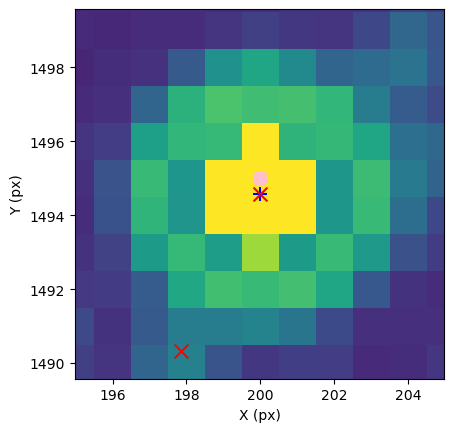

 star  433  dist= 0.004029659277081219


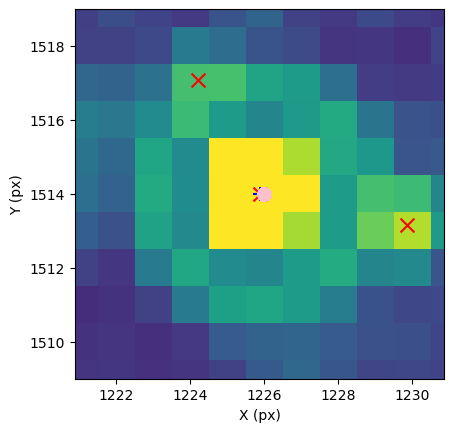

 star  440  dist= 0.0037086724561424715


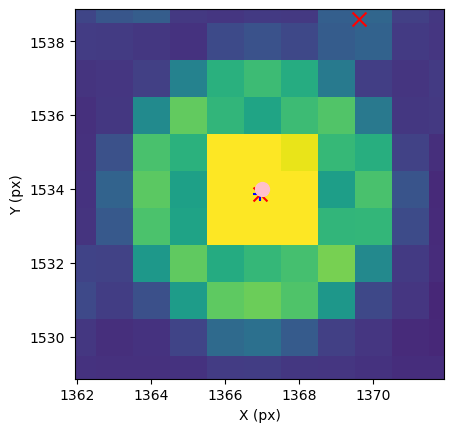

 star  442  dist= 0.008024351296492295


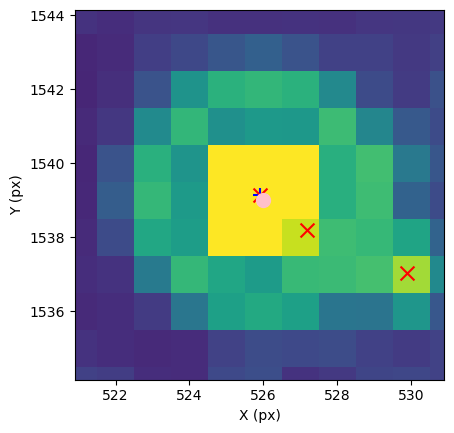

 star  449  dist= 0.0027768369478276245


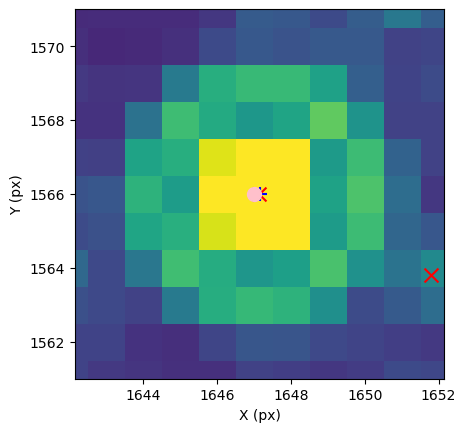

 star  450  dist= 0.004896932268956505


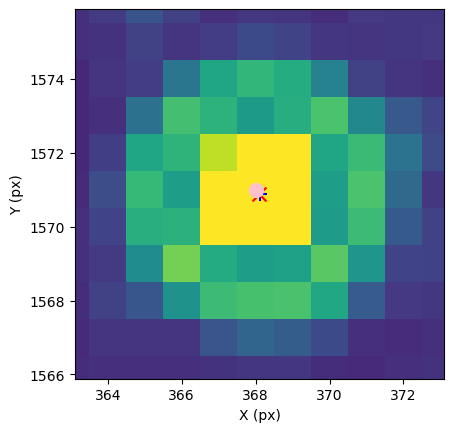

 star  461  dist= 0.0033609359843805135


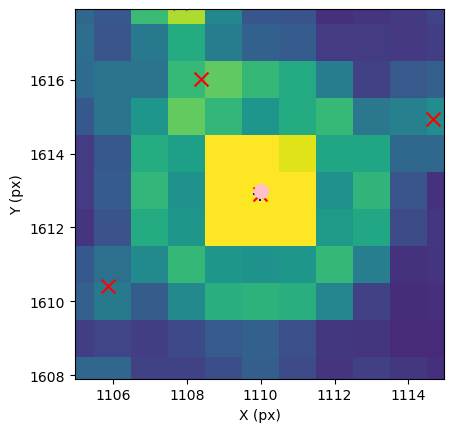

 star  495  dist= 0.004463427807059715


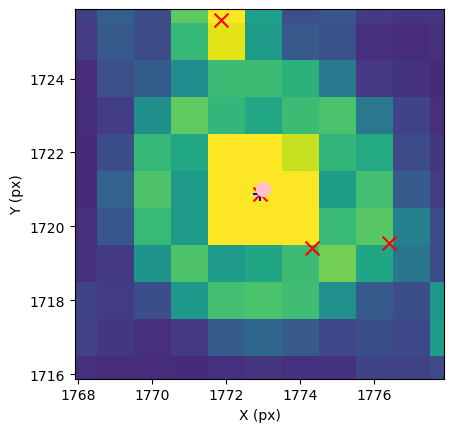

 star  506  dist= 0.0033302951575307337


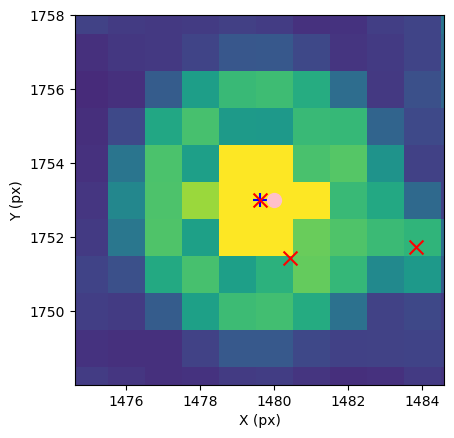

In [29]:
# good ones
print(' dx and dy mean = ', dx_mean, dy_mean)
print(' N (dist<0.0085)=', len(dist[dist<0.0085]))
for i in range(len(dist)):
    if dist[i]<0.0085: 
        print(' star ', i, ' dist=', dist[i])
        plt.imshow(data, norm=norm, origin='lower', cmap='viridis')
        plt.scatter(xc_array[i,2], xc_array[i,3], s=100, c='blue', marker='+')
        plt.scatter(original[original[:, 6]<17.0, 3]-1+dx_mean, original[original[:,6]<17.0, 2]-1+dy_mean, s=100, c='red', marker='x')
        plt.scatter(peaks_tbl['x_peak'], peaks_tbl['y_peak'], s=100, c='pink', marker='o')
        plt.xlabel('X (px)')
        plt.ylabel('Y (px)')
        plt.xlim(xc_array[i,2]-5.0, xc_array[i,2]+5.0)
        plt.ylim(xc_array[i,3]-5.0,xc_array[i,3]+5.0)
        plt.show()

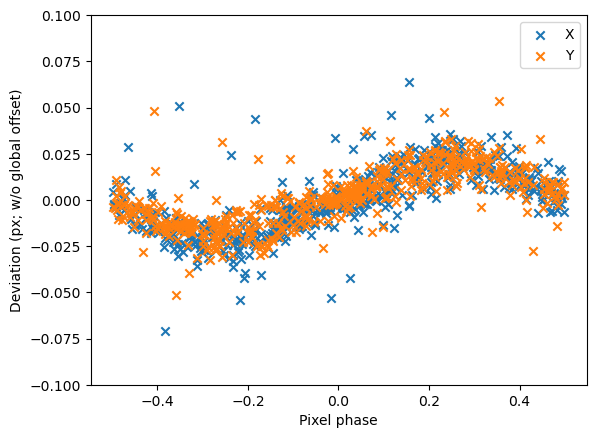

In [30]:
# Making pix-phase error data.
plt.scatter(xc_array[:,0]-(xc_array[:,0]+0.5).astype('int'), dx0, marker='x', label='X')
plt.scatter(xc_array[:,1]-(xc_array[:,1]+0.5).astype('int'), dy0, marker='x', label='Y')
#    plt.xlabel('$\Delta$x (px; w/o global offset)')
#    plt.ylabel('$\Delta$y (px; w/o global offset)')
#    plt.xlim([-0.03-0.98,0.03-0.98])
#    plt.ylim([-0.03-0.98,0.03-0.98])
# plt.xlim([-0.1,0.1])
plt.ylim([-0.1,0.1])
plt.xlabel('Pixel phase')
plt.ylabel('Deviation (px; w/o global offset)')
plt.legend()
plt.show()
    

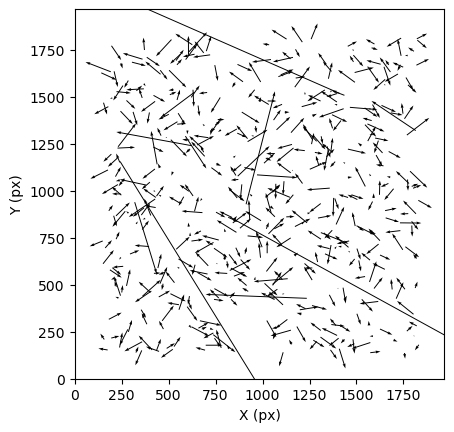

In [31]:
plt.axes().set_aspect('equal')
plt.quiver(xc_array[:,2], xc_array[:,3], dx0, dy0,
               angles='xy', scale_units='xy', scale=0.0003)
plt.xlabel('X (px)')
plt.ylabel('Y (px)')
plt.xlim([0, 1968])
plt.ylim([0, 1968])
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


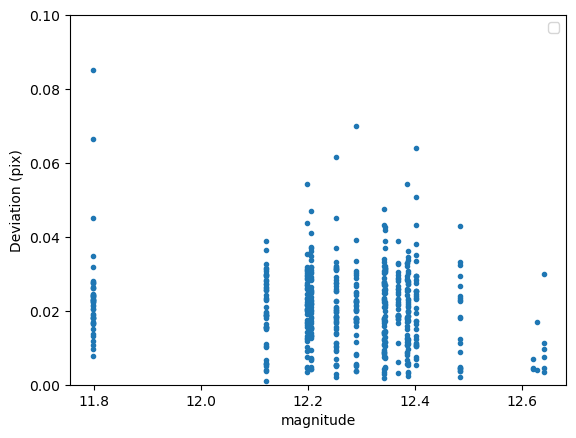

In [32]:
plt.scatter(xc_array[:, 4], dist, marker='.')
plt.ylim([0.0,0.1])
plt.xlabel('magnitude')
plt.ylabel('Deviation (pix)')
plt.legend()
plt.show()

### Apply pixel size of 472 mas/pix

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


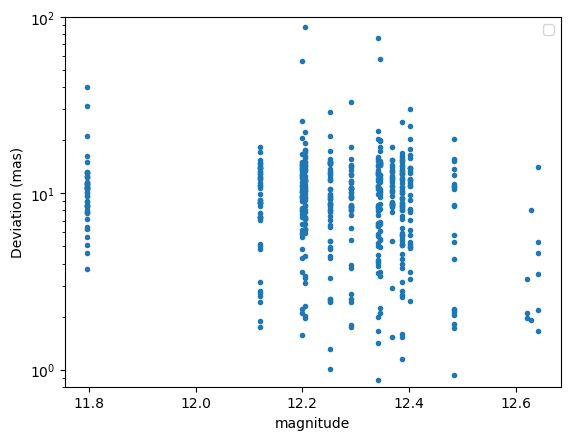

In [33]:
pixmas = 472.0
plt.scatter(xc_array[:, 4], dist*pixmas, marker='.')
plt.ylim([0.8,100.0])
plt.xlabel('magnitude')
plt.ylabel('Deviation (mas)')
plt.yscale('log')
plt.legend()
plt.show()

### make a new star table for ePSF fit from the well fitted stars

In [34]:
distlim = 0.04
goodstars_tbl = Table()
goodstars_tbl['x'] = xc_array[dist<distlim,2].astype('int')
goodstars_tbl['y'] = xc_array[dist<distlim,3].astype('int')

In [35]:
print(goodstars_tbl)

 x    y  
---- ----
1755  136
 325  139
1573  138
1109  140
 448  145
 434  148
 356  150
 ...  ...
1211 1792
1824 1802
 514 1805
1127 1808
1258 1808
1821 1810
1737 1813
Length = 495 rows


In [36]:
# Extracting stellar images.
ext_size  = 9
nddata_sel = NDData(data=data)
print(nddata_sel.data.shape)
stars_sel = extract_stars(nddata_sel, goodstars_tbl, size=ext_size)

(1968, 1968)


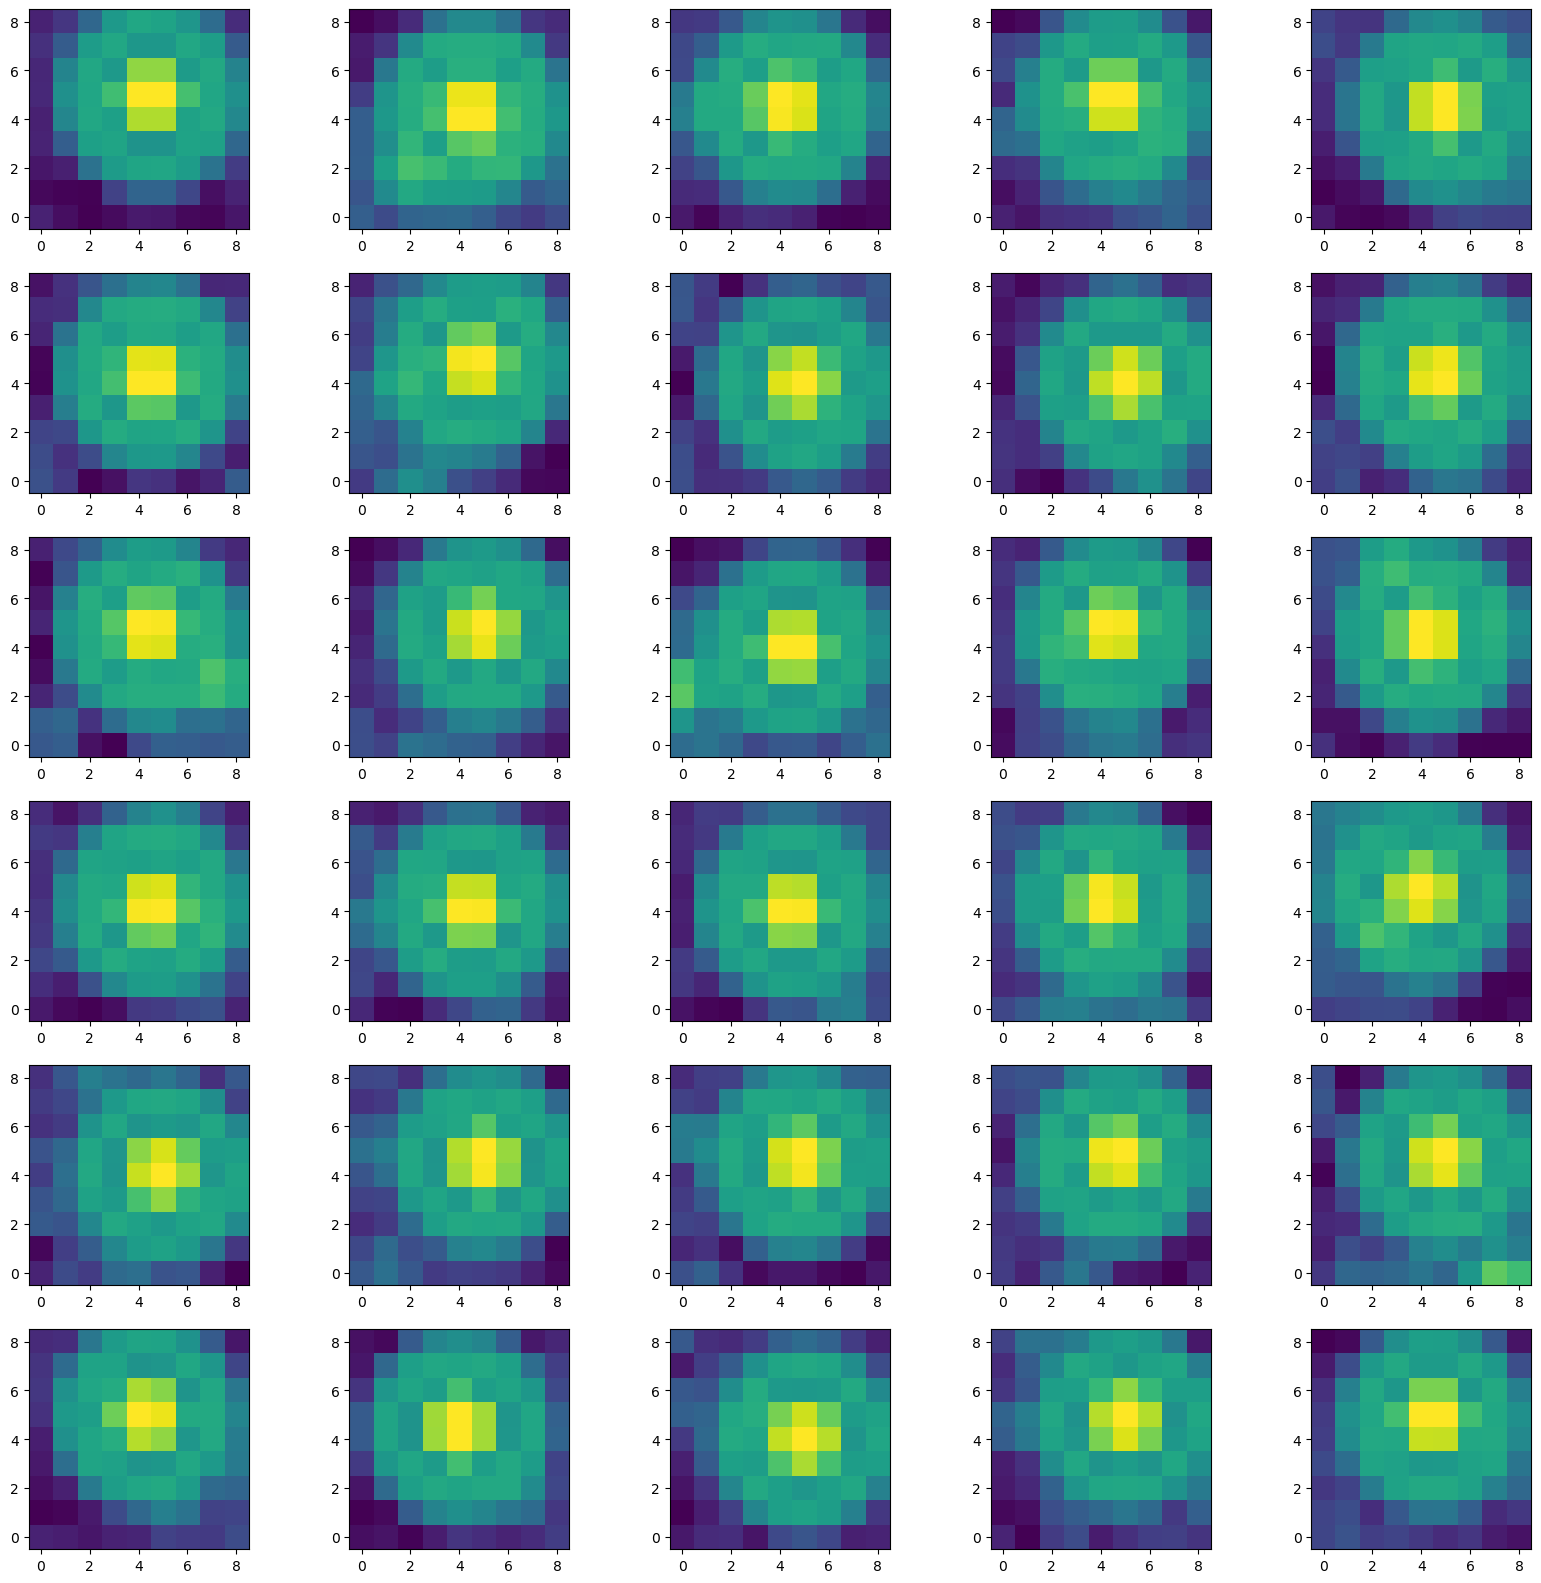

In [37]:
nrows = 6
ncols = 5
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20), squeeze=True)
ax = ax.ravel()
for i in range(nrows*ncols):
    norm_sel = simple_norm(stars_sel[i], 'log', percent=99.)
    ax[i].imshow(stars_sel[i], norm=norm_sel, origin='lower', cmap='viridis')
plt.show()

### Make ePSF

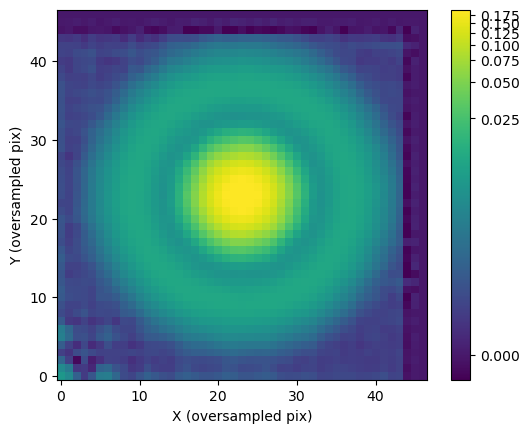

In [38]:
# Making ePSF.
n_oversample = 5 # Number of oversampling for ePSF.
n_maxiter    = 3 # Max. number of iteration for making ePSF.
norm_radius  = 5.5 # Number of undersampled pixels which determines the radius for flux normalization of ePSF.
recentering_boxsize = 5 #  Number of undersampled pixels which determines the box size for ePSF recentering calculation.

epsf_builder_sel = EPSFBuilder(oversampling=n_oversample,
                           maxiters=n_maxiter, progress_bar=False,
                           norm_radius=norm_radius, recentering_boxsize=recentering_boxsize,
                           center_accuracy=0.001)
epsf_sel, fitted_stars_sel = epsf_builder_sel(stars_sel)
norm_sel = simple_norm(epsf_sel.data, 'log', percent=99.)
    
plt.imshow(epsf_sel.data, norm=norm_sel, origin='lower', cmap='viridis')
plt.xlabel('X (oversampled pix)')
plt.ylabel('Y (oversampled pix)')
plt.colorbar()
plt.show()

number of stars brighter than  12.5 = 585


(200.0, 400.0)

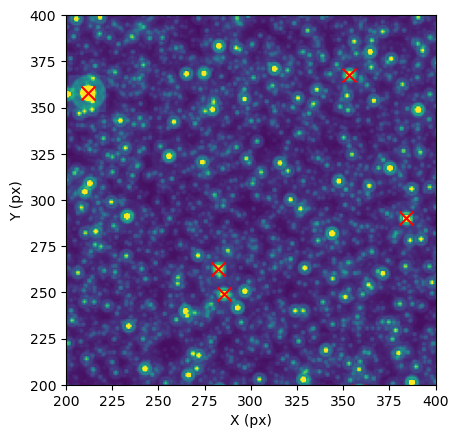

In [39]:
# Subtracting background.
maglimit = 12.5
norm_sel = simple_norm(data, 'sqrt', percent=99.)
print('number of stars brighter than ', maglimit, '=', len(original[original[:,6]<maglimit, 2]))
plt.imshow(data, norm=norm_sel, origin='lower', cmap='viridis')
plt.scatter(original[original[:, 6]<maglimit, 3]-1, original[original[:,6]<maglimit, 2]-1, s=100, c='red', marker='x')
plt.xlabel('X (px)')
plt.ylabel('Y (px)')
plt.xlim(200, 400)
plt.ylim(200, 400)


In [40]:
# Cross-matching the data.
xc_sel_array = []
maglim_o = maglimit+1.0
# search stars only for brighter stars
stars_sel_list = original[original[:, 6] < maglim_o]
print(np.shape(stars_sel_list))

# for loop for fitted stars
nfitted_stars_sel = len(fitted_stars_sel.center_flat[:, 0])
print(' N fitted stars=', np.shape(fitted_stars_sel.center_flat), nfitted_stars_sel)
print(' fitted_stars.center_flat', np.shape(fitted_stars_sel.center_flat[0]))
for i in range(nfitted_stars_sel):
    xdiff = fitted_stars_sel.center_flat[i, 0]-stars_sel_list[:, 3]+1.0
    ydiff = fitted_stars_sel.center_flat[i, 1]-stars_sel_list[:, 2]+1.0
    dist2 = xdiff**2+ydiff**2
    # closest
    mindx = np.argmin(dist2)
    # print(' indx, dist, x, y s, f=', mindx, dist2[mindx], o[3]-1.0, o[2]-1.0, fitted_stars.center_flat[mindx])
    # print(dist2[mindx], stars_list[mindx, 3]-1.,stars_list[mindx, 2]-1.,fitted_stars.center_flat[i, 0], fitted_stars.center_flat[i, 1])
    xc_sel_array.append([stars_sel_list[mindx, 3]-1.,stars_sel_list[mindx, 2]-1.,      # 1-origin -> 0-origin
                             fitted_stars_sel.center_flat[i, 0],
                             fitted_stars_sel.center_flat[i, 1],  stars_sel_list[mindx, 6]])
    if dist2[mindx]>0.6: 
        print(' star ', i, ' min dist =', np.sqrt(dist2[mindx]), stars_sel_list[mindx, 6])
        plt.imshow(data, norm=norm_sel, origin='lower', cmap='viridis')
        plt.scatter(fitted_stars_sel.center_flat[i, 0], fitted_stars_sel.center_flat[i, 1], s=100, c='blue', marker='+')
        plt.scatter(original[original[:, 6]<maglim_o, 3]-1, original[original[:,6]<maglim_o, 2]-1, s=100, c='red', marker='x')
        plt.xlabel('X (px)')
        plt.ylabel('Y (px)')
        plt.xlim(fitted_stars_sel.center_flat[i, 0]-5.0, fitted_stars_sel.center_flat[i, 0]+5.0)
        plt.ylim(fitted_stars_sel.center_flat[i, 1]-5.0, fitted_stars_sel.center_flat[i, 1]+5.0)
        plt.show()
xc_sel_array = np.array(xc_sel_array)
print(' number of stars brighter than ', maglim_o, ' in the list =', len(xc_sel_array))

(1990, 7)
 N fitted stars= (495, 2) 495
 fitted_stars.center_flat (2,)
 number of stars brighter than  13.5  in the list = 495


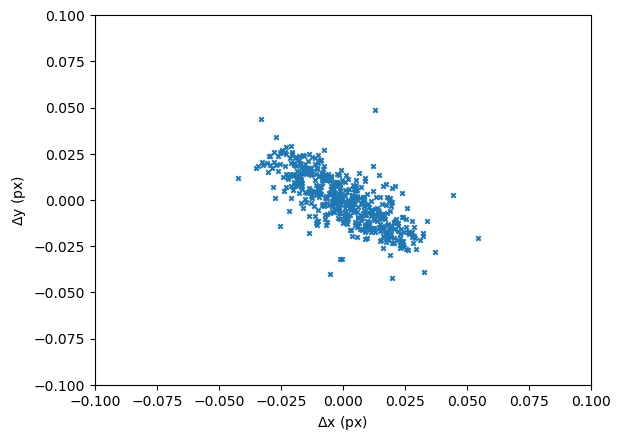

 number of stars fitted = 495
 mean deviation for dist = 0.017823805184063235
 std deviation for dist = 0.010613125739988755


In [41]:
# Making dx/dy data.
dx_sel = xc_sel_array[:,2] - xc_sel_array[:,0]
dy_sel = xc_sel_array[:,3] - xc_sel_array[:,1]
dx0_sel = dx_sel - np.mean(dx_sel)
dy0_sel = dy_sel - np.mean(dy_sel)
dx_mean_sel = np.mean(dx_sel)
dy_mean_sel = np.mean(dy_sel)
dist_sel = np.sqrt(dx0_sel**2+dy0_sel**2)
plt.scatter(dx0_sel, dy0_sel, s=10, marker='x')
plt.xlabel('$\Delta$x (px)')
plt.ylabel('$\Delta$y (px)')
plt.xlim([-0.1,0.1])
plt.ylim([-0.1,0.1])
plt.show()
print(' number of stars fitted =', len(dist_sel))
print(' mean deviation for dist =', np.mean(dist_sel))
print(' std deviation for dist =', np.std(dist_sel))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


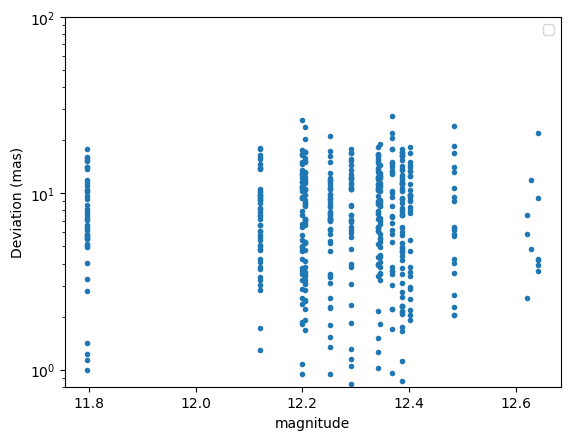

In [42]:
pixmas = 472.0
plt.scatter(xc_sel_array[:, 4], dist_sel*pixmas, marker='.')
plt.ylim([0.8,100.0])
plt.xlabel('magnitude')
plt.ylabel('Deviation (mas)')
plt.yscale('log')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


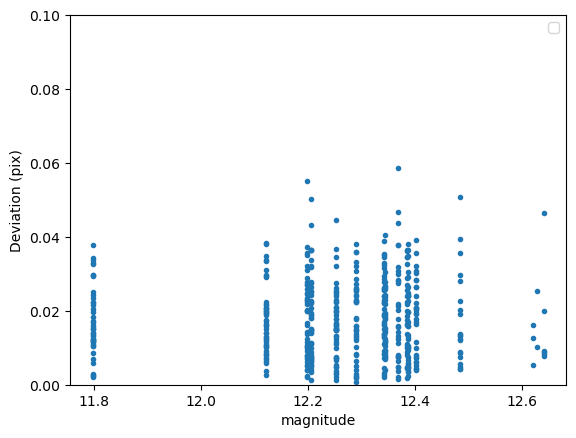

In [43]:
plt.scatter(xc_sel_array[:, 4], dist_sel, marker='.')
plt.ylim([0.0,0.1])
plt.xlabel('magnitude')
plt.ylabel('Deviation (pix)')
plt.legend()
plt.show()

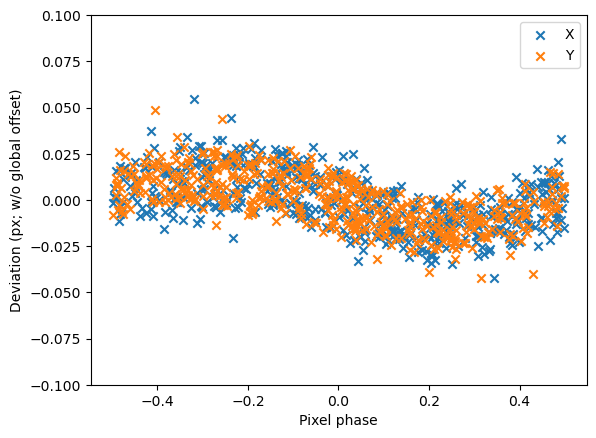

In [44]:
# Making pix-phase error data.
plt.scatter(xc_sel_array[:,0]-(xc_sel_array[:,0]+0.5).astype('int'), dx0_sel, marker='x', label='X')
plt.scatter(xc_sel_array[:,1]-(xc_sel_array[:,1]+0.5).astype('int'), dy0_sel, marker='x', label='Y')
#    plt.xlabel('$\Delta$x (px; w/o global offset)')
#    plt.ylabel('$\Delta$y (px; w/o global offset)')
#    plt.xlim([-0.03-0.98,0.03-0.98])
#    plt.ylim([-0.03-0.98,0.03-0.98])
# plt.xlim([-0.1,0.1])
plt.ylim([-0.1,0.1])
plt.xlabel('Pixel phase')
plt.ylabel('Deviation (px; w/o global offset)')
plt.legend()
plt.show()

 star  67  dist= 0.058515130156542514


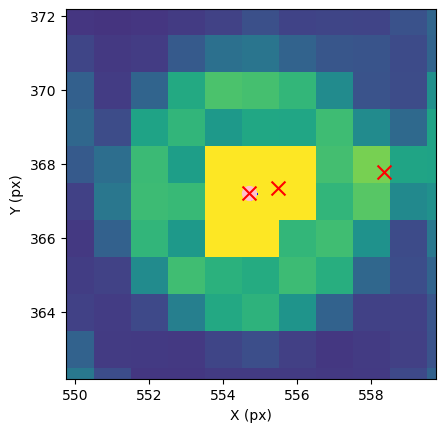

 star  76  dist= 0.04648849326398873


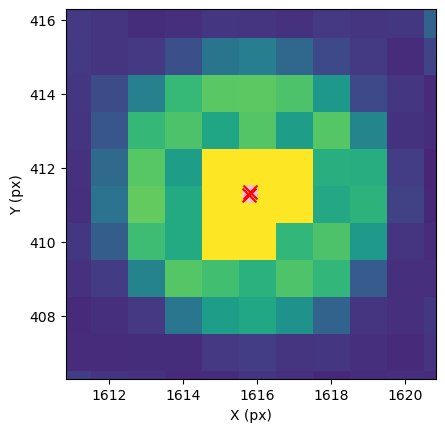

 star  153  dist= 0.04317678724744511


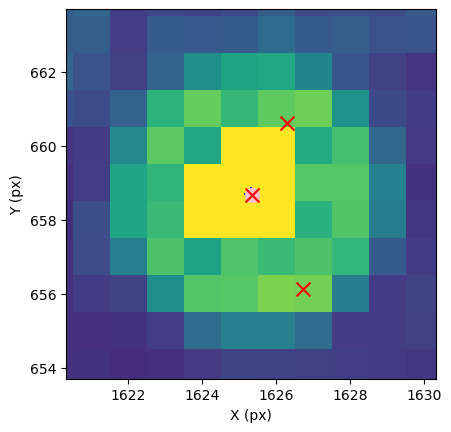

 star  199  dist= 0.05091318457334557


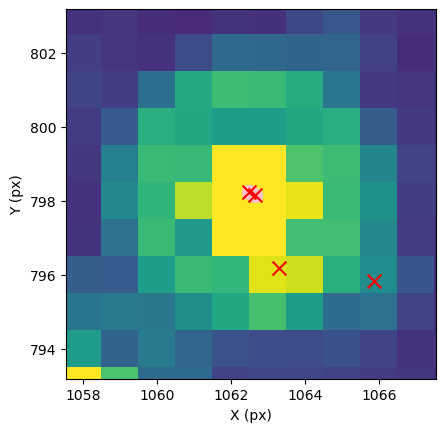

 star  273  dist= 0.05502554873702219


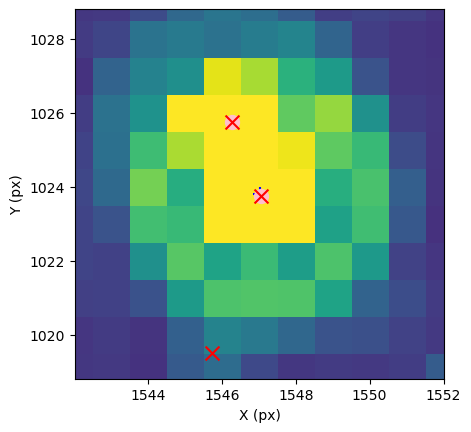

 star  308  dist= 0.05036507107858605


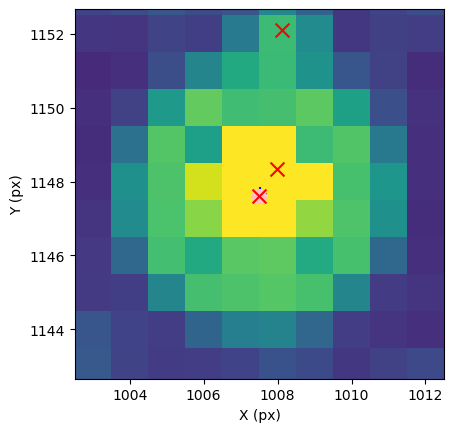

 star  333  dist= 0.04388036093163061


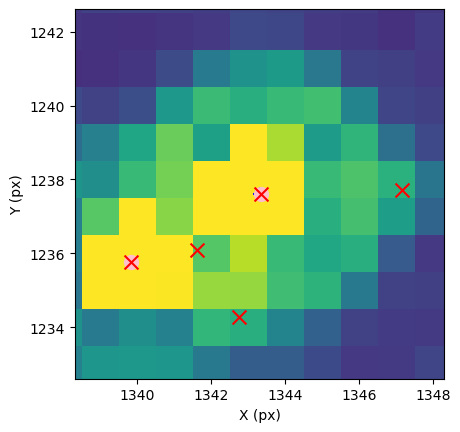

 star  337  dist= 0.046779887240023625


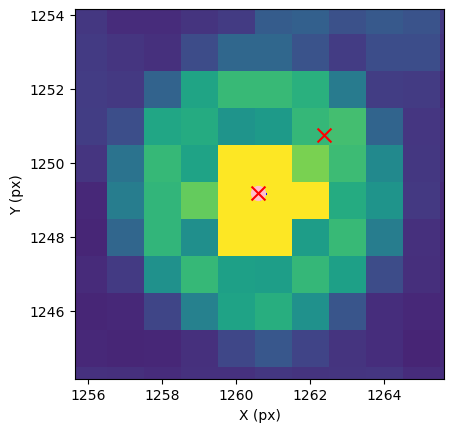

 star  377  dist= 0.044677360217150366


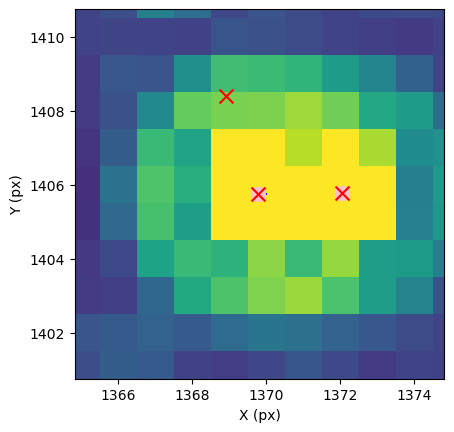

 star  446  dist= 0.04037933977925551


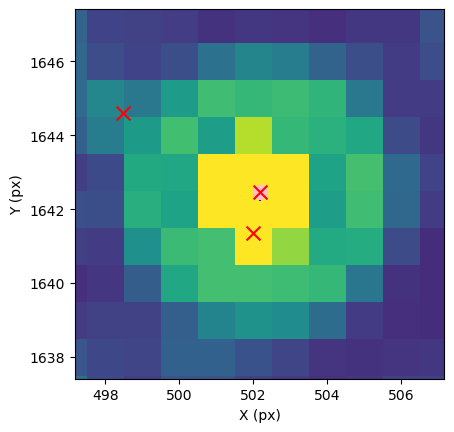

In [45]:
# examples of worse cases
for i in range(len(dist_sel)):
    if dist_sel[i]>0.04: 
        print(' star ', i, ' dist=', dist_sel[i])
        plt.imshow(data, norm=norm_sel, origin='lower', cmap='viridis')
        plt.scatter(xc_sel_array[i,2], xc_sel_array[i,3], s=100, c='blue', marker='+')
        plt.scatter(original[original[:, 6]<15.0, 3]-1+dx_mean_sel, original[original[:,6]<15.0, 2]-1+dy_mean_sel, s=100, c='pink', marker='o')
        plt.scatter(original[original[:, 6]<17.0, 3]-1+dx_mean_sel, original[original[:,6]<17.0, 2]-1+dy_mean_sel, s=100, c='red', marker='x')
        # plt.scatter(xc_array[i,0]+dx_mean, xc_array[i,1]+dx_mean, s=100, c='red', marker='x')
        plt.xlabel('X (px)')
        plt.ylabel('Y (px)')
        plt.xlim(xc_sel_array[i,2]-5.0, xc_sel_array[i,2]+5.0)
        plt.ylim(xc_sel_array[i,3]-5.0,xc_sel_array[i,3]+5.0)
        plt.show()

### One more iteration to get rid of low quality data.

In [46]:
distlim = 0.04
stars_sel2_tbl = Table()
stars_sel2_tbl['x'] = xc_sel_array[dist_sel<distlim,2].astype('int')
stars_sel2_tbl['y'] = xc_sel_array[dist_sel<distlim,3].astype('int')
print(stars_sel2_tbl)

 x    y  
---- ----
1755  136
 325  139
1573  138
1109  140
 448  145
 434  148
 356  150
 ...  ...
1211 1792
1824 1802
 514 1805
1127 1808
1258 1808
1821 1810
1737 1813
Length = 485 rows


In [47]:
# Extracting stellar images.
ext_size  = 9
nddata_sel2 = NDData(data=data)
print(nddata_sel2.data.shape)
stars_sel2 = extract_stars(nddata_sel2, stars_sel2_tbl, size=ext_size)

(1968, 1968)


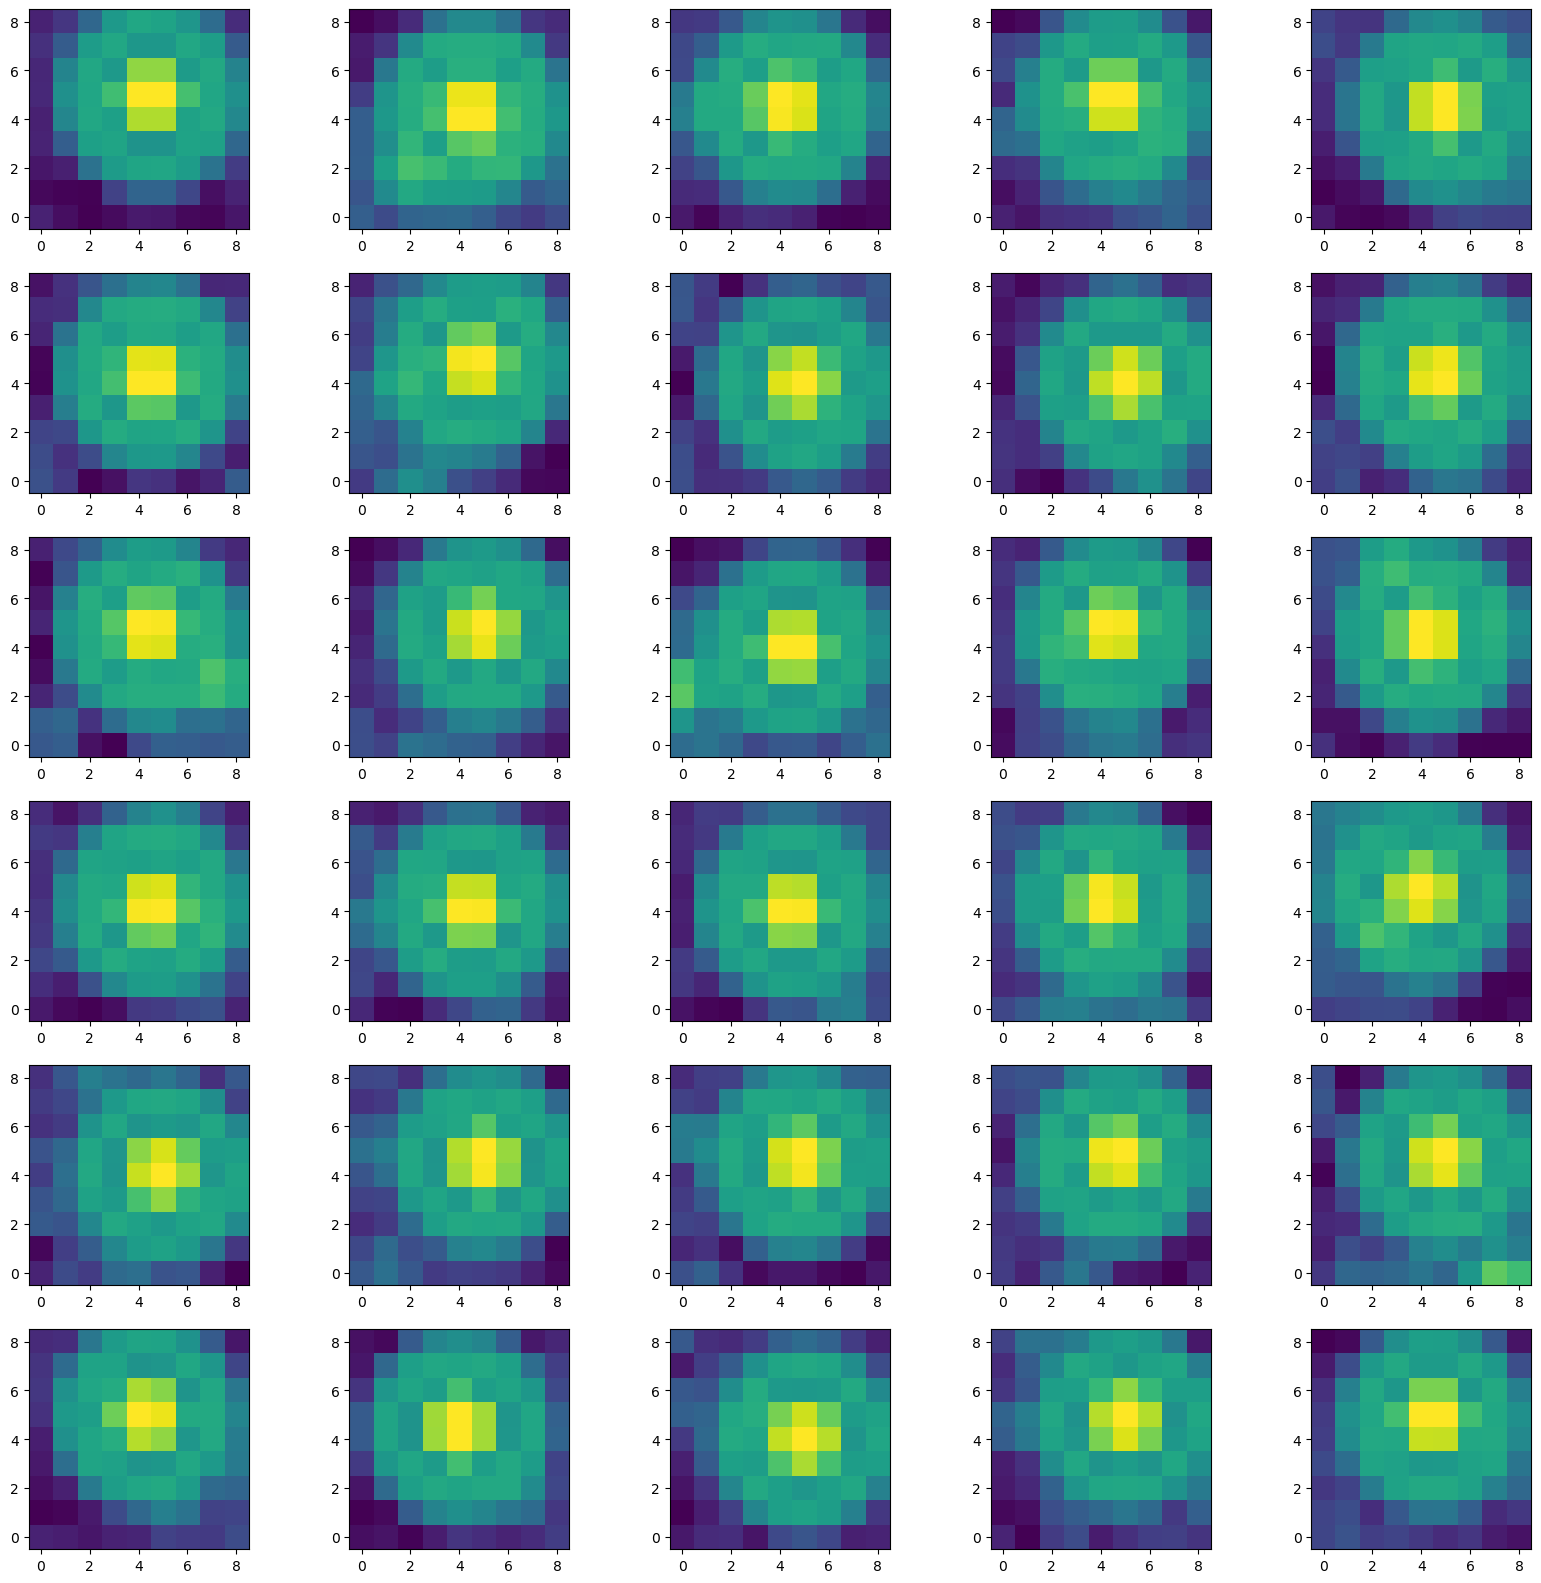

In [48]:
nrows = 6
ncols = 5
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20), squeeze=True)
ax = ax.ravel()
for i in range(nrows*ncols):
    norm_sel2 = simple_norm(stars_sel2[i], 'log', percent=99.)
    ax[i].imshow(stars_sel2[i], norm=norm_sel2, origin='lower', cmap='viridis')
plt.show()

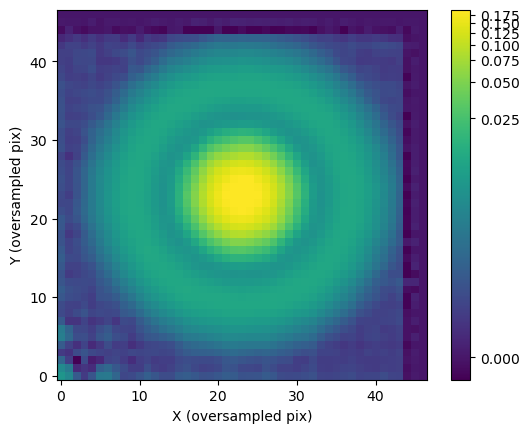

In [49]:
# Making ePSF.
n_oversample = 5 # Number of oversampling for ePSF.
n_maxiter    = 3 # Max. number of iteration for making ePSF.
norm_radius  = 5.5 # Number of undersampled pixels which determines the radius for flux normalization of ePSF.
recentering_boxsize = 5 #  Number of undersampled pixels which determines the box size for ePSF recentering calculation.

epsf_builder_sel2 = EPSFBuilder(oversampling=n_oversample,
                           maxiters=n_maxiter, progress_bar=False,
                           norm_radius=norm_radius, recentering_boxsize=recentering_boxsize,
                           center_accuracy=0.001)
epsf_sel2, fitted_stars_sel2 = epsf_builder_sel(stars_sel2)
norm_sel2 = simple_norm(epsf_sel2.data, 'log', percent=99.)
    
plt.imshow(epsf_sel2.data, norm=norm_sel2, origin='lower', cmap='viridis')
plt.xlabel('X (oversampled pix)')
plt.ylabel('Y (oversampled pix)')
plt.colorbar()
plt.show()

number of stars brighter than  12.5 = 585


(200.0, 400.0)

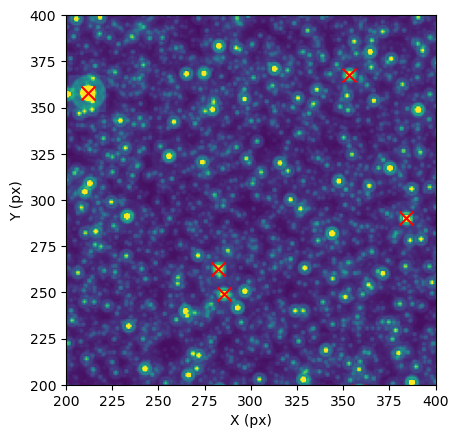

In [50]:
# Subtracting background.
maglimit = 12.5
norm_sel2 = simple_norm(data, 'sqrt', percent=99.)
print('number of stars brighter than ', maglimit, '=', len(original[original[:,6]<maglimit, 2]))
plt.imshow(data, norm=norm_sel2, origin='lower', cmap='viridis')
plt.scatter(original[original[:, 6]<maglimit, 3]-1, original[original[:,6]<maglimit, 2]-1, s=100, c='red', marker='x')
plt.xlabel('X (px)')
plt.ylabel('Y (px)')
plt.xlim(200, 400)
plt.ylim(200, 400)


In [51]:
# Cross-matching the data.
xc_sel2_array = []
maglim_o = maglimit+1.0
# search stars only for brighter stars
stars_sel2_list = original[original[:, 6] < maglim_o]
print(np.shape(stars_sel2_list))

# for loop for fitted stars
nfitted_stars_sel2 = len(fitted_stars_sel2.center_flat[:, 0])
print(' N fitted stars=', np.shape(fitted_stars_sel2.center_flat), nfitted_stars_sel2)
print(' fitted_stars.center_flat', np.shape(fitted_stars_sel2.center_flat[0]))
for i in range(nfitted_stars_sel2):
    xdiff = fitted_stars_sel2.center_flat[i, 0]-stars_sel2_list[:, 3]+1.0
    ydiff = fitted_stars_sel2.center_flat[i, 1]-stars_sel2_list[:, 2]+1.0
    dist2 = xdiff**2+ydiff**2
    # closest
    mindx = np.argmin(dist2)
    # print(' indx, dist, x, y s, f=', mindx, dist2[mindx], o[3]-1.0, o[2]-1.0, fitted_stars.center_flat[mindx])
    # print(dist2[mindx], stars_list[mindx, 3]-1.,stars_list[mindx, 2]-1.,fitted_stars.center_flat[i, 0], fitted_stars.center_flat[i, 1])
    xc_sel2_array.append([stars_sel2_list[mindx, 3]-1.,stars_sel2_list[mindx, 2]-1.,      # 1-origin -> 0-origin
                             fitted_stars_sel2.center_flat[i, 0],
                             fitted_stars_sel2.center_flat[i, 1],  stars_sel2_list[mindx, 6]])
    if dist2[mindx]>0.6: 
        print(' star ', i, ' min dist =', np.sqrt(dist2[mindx]), stars_sel2_list[mindx, 6])
        plt.imshow(data, norm=norm_sel2, origin='lower', cmap='viridis')
        plt.scatter(fitted_stars_sel2.center_flat[i, 0], fitted_stars_sel2.center_flat[i, 1], s=100, c='blue', marker='+')
        plt.scatter(original[original[:, 6]<maglim_o, 3]-1, original[original[:,6]<maglim_o, 2]-1, s=100, c='red', marker='x')
        plt.xlabel('X (px)')
        plt.ylabel('Y (px)')
        plt.xlim(fitted_stars_sel2.center_flat[i, 0]-5.0, fitted_stars_sel2.center_flat[i, 0]+5.0)
        plt.ylim(fitted_stars_sel2.center_flat[i, 1]-5.0, fitted_stars_sel2.center_flat[i, 1]+5.0)
        plt.show()
xc_sel2_array = np.array(xc_sel2_array)
print(' number of stars brighter than ', maglim_o, ' in the list =', len(xc_sel2_array))

(1990, 7)
 N fitted stars= (485, 2) 485
 fitted_stars.center_flat (2,)
 number of stars brighter than  13.5  in the list = 485


In [52]:
print(np.shape(xc_sel2_array))

(485, 5)


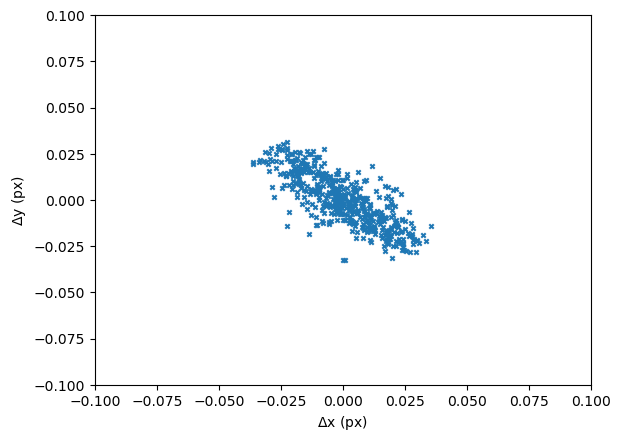

 number of stars fitted = 485
 mean deviation for dist = 0.017954893478478735
 std deviation for dist = 0.010363942542592925


In [53]:
# Making dx/dy data.
dx_sel2 = xc_sel2_array[:,2] - xc_sel2_array[:,0]
dy_sel2 = xc_sel2_array[:,3] - xc_sel2_array[:,1]
dx0_sel2 = dx_sel2 - np.mean(dx_sel2)
dy0_sel2 = dy_sel2 - np.mean(dy_sel2)
dx_mean_sel2 = np.mean(dx_sel2)
dy_mean_sel2 = np.mean(dy_sel2)
dist_sel2 = np.sqrt(dx0_sel2**2+dy0_sel2**2)
plt.scatter(dx0_sel2, dy0_sel2, s=10, marker='x')
plt.xlabel('$\Delta$x (px)')
plt.ylabel('$\Delta$y (px)')
plt.xlim([-0.1,0.1])
plt.ylim([-0.1,0.1])
plt.show()
print(' number of stars fitted =', len(dist_sel2))
print(' mean deviation for dist =', np.mean(dist_sel2))
print(' std deviation for dist =', np.std(dist_sel2))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


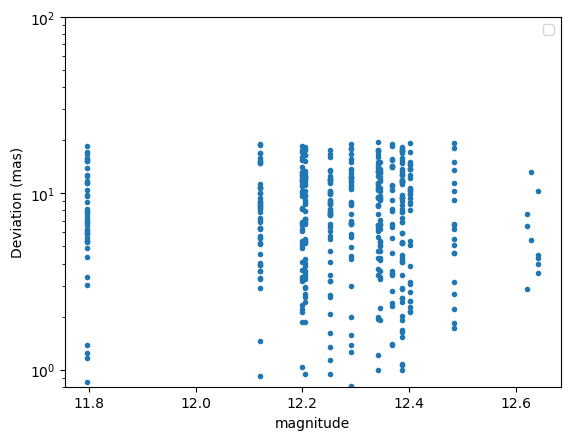

 N star (<4 mas) = 109


In [54]:
pixmas = 472.0
plt.scatter(xc_sel2_array[:, 4], dist_sel2*pixmas, marker='.')
plt.ylim([0.8,100.0])
plt.xlabel('magnitude')
plt.ylabel('Deviation (mas)')
plt.yscale('log')
plt.legend()
plt.show()
distmas_sel2 = dist_sel2*pixmas
print(' N star (<4 mas) =', len(distmas_sel2[distmas_sel2<4.0]))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


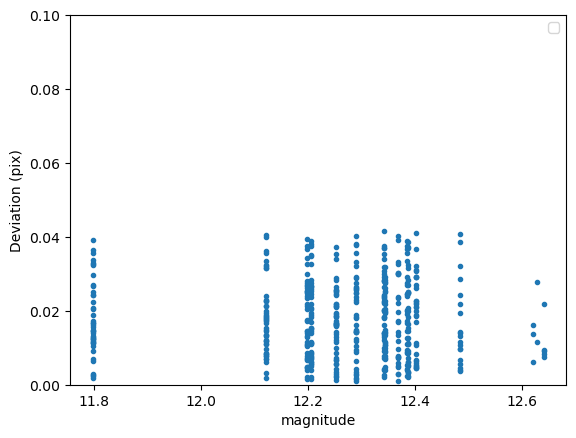

In [55]:
plt.scatter(xc_sel2_array[:, 4], dist_sel2, marker='.')
plt.ylim([0.0,0.1])
plt.xlabel('magnitude')
plt.ylabel('Deviation (pix)')
plt.legend()
plt.show()

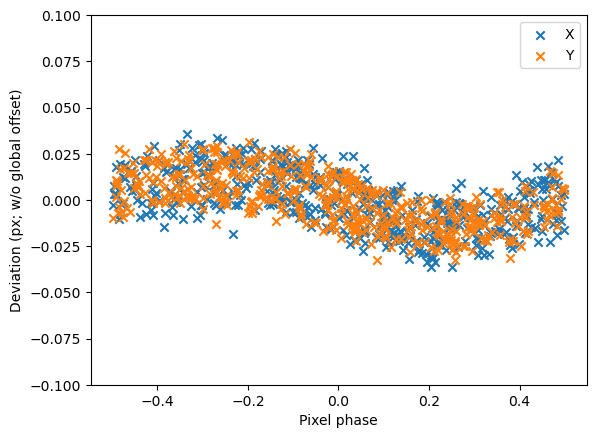

In [56]:
# Making pix-phase error data.
plt.scatter(xc_sel2_array[:,0]-(xc_sel2_array[:,0]+0.5).astype('int'), dx0_sel2, marker='x', label='X')
plt.scatter(xc_sel2_array[:,1]-(xc_sel2_array[:,1]+0.5).astype('int'), dy0_sel2, marker='x', label='Y')
#    plt.xlabel('$\Delta$x (px; w/o global offset)')
#    plt.ylabel('$\Delta$y (px; w/o global offset)')
#    plt.xlim([-0.03-0.98,0.03-0.98])
#    plt.ylim([-0.03-0.98,0.03-0.98])
# plt.xlim([-0.1,0.1])
plt.ylim([-0.1,0.1])
plt.xlabel('Pixel phase')
plt.ylabel('Deviation (px; w/o global offset)')
plt.legend()
plt.show()